## Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as web
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import joblib as jb


# Optimize Savings

## Preprocessing

Raw dataset Rows = 41544 and Columns = 60.
Filterred dataset Rows = 41544 and Columns = 18.
Training data: (33235, 17)
Testing data: (8309, 17)
Multiple Linear Regression Score: 1.0
People in debt: 3436
Debt percentage in population 10.34


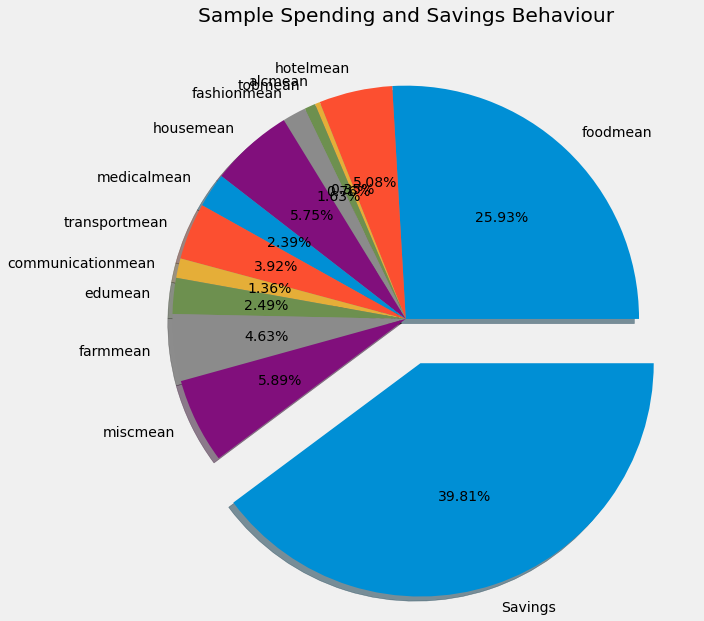

In [2]:
raw = pd.read_csv("Family Income and Expenditure.csv")
#raw
#raw.columns
print("Raw dataset Rows = {} and Columns = {}.".format(raw.shape[0],raw.shape[1]))
#Dataset Filtering
raw.drop(columns=['Region',
                  'Agricultural Household indicator',
                  'Main Source of Income',
                  'Household Head Highest Grade Completed',
                  'Household Head Job or Business Indicator', 
                  'Household Head Occupation',
                  'Household Head Class of Worker',
                  'Type of Household',
                  'Type of Building/House',
                  'Type of Roof',
                  'Type of Walls',
                  'House Floor Area',
                  'House Age',
                  'Number of bedrooms',
                  'Tenure Status',
                  'Toilet Facilities',
                  'Electricity',
                  'Main Source of Water Supply',
                  'Number of Television',
                  'Number of CD/VCD/DVD', 
                  'Number of Component/Stereo set',
                  'Number of Refrigerator/Freezer', 
                  'Number of Washing Machine',
                  'Number of Airconditioner',
                  'Number of Car, Jeep, Van',
                  'Number of Landline/wireless telephones',
                  'Number of Cellular phone',
                  'Number of Personal Computer',
                  'Number of Stove with Oven/Gas Range',
                  'Number of Motorized Banca',
                  'Number of Motorcycle/Tricycle',
                  'Members with age less than 5 year old',
                  'Members with age 5 - 17 years old',
                  'Total number of family members employed',], inplace = True)

#raw.info()

#Copy to a new dataset
dataset1=pd.DataFrame()
#dataset1[''] = raw['']
dataset1['Total Household Income'] = raw['Total Household Income'] + raw['Total Income from Entrepreneurial Acitivites']

dataset1['Total Food Expenditure']= (raw['Bread and Cereals Expenditure']+ raw['Total Rice Expenditure']
                                     +raw['Meat Expenditure']+raw['Total Fish and  marine products Expenditure']
                                     +raw['Fruit Expenditure']+raw['Vegetables Expenditure'])

dataset1['Restaurant and hotels Expenditure'] = raw['Restaurant and hotels Expenditure']

dataset1['Alcoholic Beverages Expenditure'] = raw['Alcoholic Beverages Expenditure']

dataset1['Tobacco Expenditure'] = raw['Tobacco Expenditure']

dataset1['Fashion Spendings'] = raw['Clothing, Footwear and Other Wear Expenditure']

dataset1['Housing Expenditure'] = raw['Housing and water Expenditure'] - raw['Imputed House Rental Value']

dataset1['Medical Expenditure'] = raw['Medical Care Expenditure']

dataset1['Transportation Expenditure'] = raw['Transportation Expenditure']

dataset1['Communication Expenditure'] = raw['Communication Expenditure']

dataset1['Education Expenditure'] = raw['Education Expenditure']

dataset1['Farming and Gardening expenses'] = raw['Crop Farming and Gardening expenses']

dataset1['Miscellaneous and Special Occasions Expenditure'] = raw['Miscellaneous Goods and Services Expenditure'] + raw['Special Occasions Expenditure']

dataset1['Sex'] = raw['Household Head Sex']

dataset1['Age'] = raw['Household Head Age']

dataset1['Marital Status'] = raw['Household Head Marital Status']

dataset1['Total Number of Family members'] = raw['Total Number of Family members']

#dataset1
#dataset1.info()

#print(raw['Total Food Expenditure'] - dataset1['Total Food Expenditure'])

# Adjusting total Food Expense:
food = pd.DataFrame()

food['Given Total Food Expenditure'] = raw['Total Food Expenditure']
food['Calculated Total Food Expenditure'] = dataset1['Total Food Expenditure']
food['Error'] = (raw['Total Food Expenditure'] - dataset1['Total Food Expenditure'])/2
food['Approximate Total Food Expenditure'] = raw['Total Food Expenditure'] - food['Error']

# Adding this adjusted value to the Dataset
dataset1['Total Food Expenditure'] = food['Approximate Total Food Expenditure']

#dataset1
#Saving This to System Disk
dataset1.to_csv('Filtered Dataset v2.csv', index=False)

# Getting Total Expense Value & Savings
dataset1['total expense'] = dataset1['Total Food Expenditure']
for i in range(2,13):
    dataset1['total expense'] = dataset1['total expense'] + dataset1.iloc[:,i]

dataset1['Savings'] = dataset1['Total Household Income'] - dataset1['total expense']

# Getting Unique Categorical Values and Encoding them in the Dataset
dataset2 = dataset1.copy()

#dataset1.iloc[:,13].unique() #Sex male = 1, female = 0

dataset2['Sex'][dataset2['Sex'] == 'Female'] = 0
dataset2['Sex'][dataset2['Sex'] == 'Male'] = 1
        
#dataset1.iloc[:,15].unique() #Relationship Status

dataset2['Marital Status'][dataset2['Marital Status'] == 'Single'] = 0
dataset2['Marital Status'][dataset2['Marital Status'] == 'Married'] = 1
dataset2['Marital Status'][dataset2['Marital Status'] == 'Widowed'] = 2
dataset2['Marital Status'][dataset2['Marital Status'] == 'Divorced/Separated'] = 3
dataset2['Marital Status'][dataset2['Marital Status'] == 'Annulled'] = 4
dataset2['Marital Status'][dataset2['Marital Status'] == 'Unknown'] = 5

dataset2.drop(columns=['total expense'], inplace=True) 
#dataset2.to_csv('Filtered, Corrected And Encoded Dataset v2.csv', index=False)
print("Filterred dataset Rows = {} and Columns = {}.".format(dataset2.shape[0],dataset2.shape[1]))


#Splitting Data
X = dataset2.iloc[:,0:-1]
Y = dataset2.iloc[:,-1]

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

print("Training data:", x_train.shape)
print("Testing data:",x_test.shape)

#Model Training
#Importing Models:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()

model1_mlr= mlr.fit(x_train,y_train)
M1=model1_mlr.score(x_train,y_train)
print("Multiple Linear Regression Score:",M1)

#Save Model
jb.dump(model1_mlr,"MLR_Training.pkl")


#Counting How many people are in debt

debt = y_train.lt(0).sum() #Less Than

print("People in debt:",debt)
print("Debt percentage in population",round(debt*100/y_train.shape[0],2))

#Making Dictionary for fast acessing
#expenditure mean dictionary creation to get the statsof population
MeanDict = {'incomemean':1 ,'foodmean':2 ,'hotelmean':3 ,'alcmean':4 ,'tobmean':5 ,'fashionmean':6 ,'housemean':7 ,
            'medicalmean':8 ,'transportmean':9 ,'communicationmean':10 ,'edumean':11 ,'farmmean':12 ,'miscmean':13 }
#print(MeanDict)
j=0
for key, value in MeanDict.items():
    MeanDict[key] = x_train.iloc[:,j].mean()
    j+=1
    if j==13:
        break
#print(MeanDict)

#Mean Percentage
spendper =0
MeanPercentDict = {}
for key,value in MeanDict.items():
    percent= MeanDict[key]*100/MeanDict['incomemean']
    MeanPercentDict[key] = percent
    spendper = spendper + percent
    #print(key,percent,"%")
spendper= spendper - 100 # -100 because 100 is in the income
#print("Total Spending Percentage", spendper) 
#print(MeanPercentDict)

#Plotting Population mean data
head = []
val = []
for i, j in MeanPercentDict.items():
    head.append(i)
    val.append(j)
head.append('Savings')
val.append(100-spendper)
head.pop(0) #removing income mean
val.pop(0) #removing income mean value
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2]
fig = plt.figure(figsize =(30, 10))
plt.title("Sample Spending and Savings Behaviour")
plt.pie(val, labels = head,autopct='%1.2f%%', explode = explode, shadow = True, radius = 1)
#plt.legend(loc = 'best')
plt.show()

         

### Testing

Current Savings Value: 21826.5


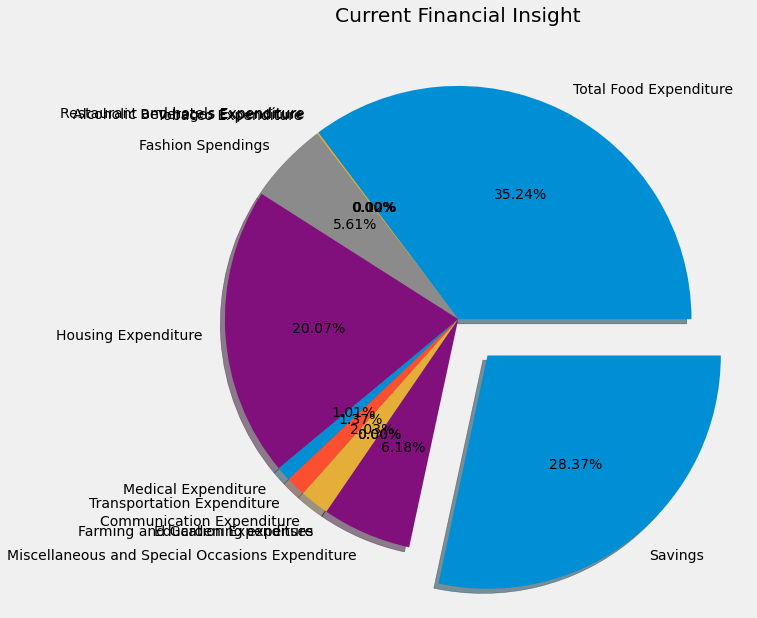

Your Savings will be 21276.09 due to Inflation.
It is a concern in fashion
You can save 1522.92 in fashion expenditure
It is a concern in house
You can save 7935.8 in house expenditure
You can save 9458.72 in the above expenditure:
You can save a total Of 31285.22 from your salary.


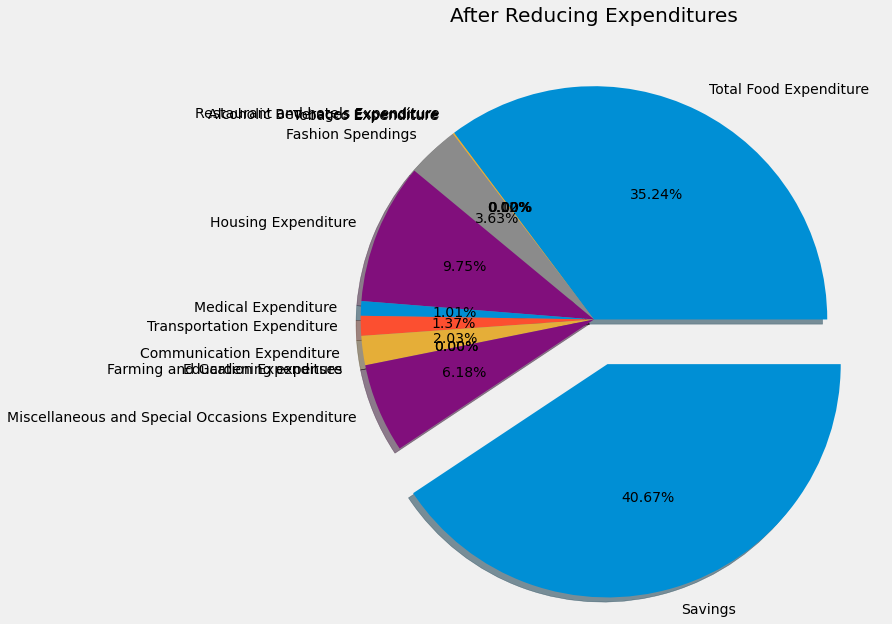

In [21]:
 ###############################################   Testing ##############################################


choose = 0



test1 = x_test.iloc[choose,:].values
test1res= y_test.iloc[choose]
#print(test1)
test1 = test1.reshape(1, -1) #make 1d array to 2d
#print(test1)

test1_pred1 = model1_mlr.predict(test1)
print("Current Savings Value:",round(test1_pred1[0],2))


expenditure_names = list(x_train.columns)
jb.dump(expenditure_names,"expenditure_names.pkl")
for i in range(4):
    expenditure_names.pop()
#print(L)

#print(expenditure_names)
expenditure_names.pop(0)
expenditure_names.append('Savings')
test1v1 = list(test1.flatten()) #2d to 1d conversion
#np.append(test1v3,round(test1_pred1[0],2))
test1v1.pop(0)
for i in range(4):
    test1v1.pop()
#print(L)
test1v1.append(test1_pred1)
#print(len(expenditure_names))

explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2]
fig = plt.figure(figsize =(30, 10))
plt.title("Current Financial Insight")
plt.pie(test1v1, labels = expenditure_names,autopct='%1.2f%%', explode = explode, shadow = True, radius = 1)
#plt.legend(loc = 0)
plt.show()

#####################  Calculating Inflation Rate ##########################
#  Purchasing Power :
#  Future Value = Present value/(1+inflation rate)^number of years
#  Dataset is of 2012. Inflation rate for 2013 is 2.5837
#  We are calculating Inflation rate for 1 year only

PurchasePower = round((test1_pred1[0]/ (1+0.02587)**1),2)

print("Your Savings will be {} due to Inflation.".format(PurchasePower))

test1v2 = test1

threshold = {'incomemean':1 ,'foodmean':14 ,'hotelmean':1 ,'alcmean':1 ,'tobmean':1 ,'fashionmean':2 ,'housemean':4 ,
            'medicalmean':20 ,'transportmean':2 ,'communicationmean':1 ,'edumean':30 ,'farmmean':2 ,'miscmean':1}
jb.dump(threshold,"threshold.pkl")

i = 0
delSave = 0
totalsave = 0
flag = 0

for key,value in MeanPercentDict.items():
    
    
    
    
    calc_per = test1v2[0][i]*100/test1v2[0][0]
    
    #print(calc_per)
    if calc_per >= MeanPercentDict[key] + threshold[key]:
        flag+=1
        print("It is a concern in",key[:-4])
        delSave = round((test1v2[0][i]) - (test1v2[0][0] * ((MeanPercentDict[key] + threshold[key])/100)), 2)
        test1v2[0][i] = test1v2[0][i] - delSave 
        print("You can save {} in {} expenditure".format(delSave,key[:-4]))
        totalsave = round(totalsave + delSave,2)
    i+=1
if flag>0:
    print("You can save {} in the above expenditure:".format(totalsave))
else:
    print("Your savings are good")
    
finalsave = totalsave + round(test1_pred1[0],2)
print("You can save a total Of {} from your salary.".format(finalsave))

test1v2 = list(test1v2.flatten()) #2d to 1d conversion
#np.append(test1v3,round(test1_pred1[0],2))
test1v2.pop(0)
for i in range(4):
    test1v2.pop()

    
test1v2.append(finalsave)    
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2]
fig = plt.figure(figsize =(30, 10))
plt.title("After Reducing Expenditures")
plt.pie(test1v2, labels = expenditure_names,autopct='%1.2f%%', explode = explode, shadow = True, radius = 1)
#plt.legend(loc = 0)
plt.show()

# Preprocessing Stocks

## Separating Different stocks

In [4]:
raw = pd.read_csv("BSE_30.csv")

#print(raw)
#print(raw.info())
#print(raw.describe())

raw = raw.dropna()
raw.reset_index(drop=True, inplace=True)

raw['Date'] = pd.to_datetime(raw['Date']).dt.date


Company = raw['Symbol'].unique()
print("Company stocks are",Company)
print("\nNumber of companies in dataset are",raw['Symbol'].nunique())

company_dict = {}
for i in Company:
    company_dict[i] = pd.DataFrame()
#print(company_dict)

for i in range(0, len(raw)):
    company_dict[raw['Symbol'][i]] = company_dict[raw['Symbol'][i]].append(raw.iloc[i,1:])

    
for name in company_dict:
    temp = company_dict[name]
    #print(temp)
    temp.to_csv(r"C:/Users/DIBYA/Capstone Project/StocksData"+ '/'+'{}.csv'.format(name),index=False)
    #print("Executing ",name)
print("Extracted to directory")

Company stocks are ['ADANIPORTS' 'ASIANPAINT' 'AXISBANK' 'BAJAJ-AUTO' 'BHARTIARTL'
 'COALINDIA' 'DRREDDY' 'HDFC' 'HDFCBANK' 'HEROMOTOCO' 'HINDUNILVR'
 'ICICIBANK' 'INDUSINDBK' 'INFY' 'ITC' 'KOTAKBANK' 'LT' 'M&M' 'MARUTI'
 'ONGC' 'RELIANCE' 'SBIN' 'SUNPHARMA' 'TATAMOTORS' 'TATAMTRDVR'
 'TATASTEEL' 'TCS' 'WIPRO' 'YESBANK' 'POWERGRID']

Number of companies in dataset are 30
Extracted to directory


## Categorizing as Low, Medium and High risk

In [5]:
def GetValues(dataset = None):
    df = dataset
    df['Returns'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    #print(df)

    nan_values = df['Returns'].isna().sum() #NaN Values count
    zero_values = df['Returns'].eq(0).sum() #Equal )
    negative_values = df['Returns'].lt(0).sum() #Less Than
    positive_values = df['Returns'].gt(0).sum() #Greater Than
    
    
    print("Total Values = {}\nNull Values = {}\nZero Values = {}\nNegative Values {}\nPositive Values {}"
          .format(nan_values + zero_values + negative_values + positive_values,
                  nan_values, zero_values, negative_values, positive_values))
    Difference = positive_values - negative_values
    percentage = (Difference*100)/(positive_values + negative_values)
    
    print("Difference = ",Difference)
    print("Difference % = ", percentage)
    if percentage <= 1.30:
        print("Stock is High Risk")
        return 'High',percentage
    elif 1.30 < percentage <= 2.7:
        print("Stock is Medium Risk")
        return 'Medium',percentage
    else:
        print("Stock is Low Risk")
        return 'Low',percentage

In [6]:
StockRisk = pd.DataFrame(columns = ['Stock', 'Risk', 'Percentage'])

path = os.getcwd()
csv_files = glob.glob(os.path.join('C:/Users/DIBYA/Capstone Project/StocksData/', "*.csv"))

risk_dict={}
# loop over the list of csv files
for f in csv_files:
    templist = []
    # read the csv file
    df = pd.read_csv(f)

    # print the location and filename
    #print('Location:', f)
    
    temp = f.split("\\")[-1]
    #print('File Name with Extension:', temp)
    print('File Name:', temp[:-4])
    
    if temp[:-4] not in risk_dict:
        df = pd.read_csv(f)

        risk_dict[temp[:-4]], percent = GetValues(dataset = df)
    
    StockRisk = StockRisk.append({'Stock':temp[:-4], 'Risk': risk_dict[temp[:-4]], 'Percentage':percent}, ignore_index= True)
    print()
    print()
    
#print("Risk Dictionary",risk_dict)
print("Risk DataFrame")
StockRisk

File Name: ADANIPORTS
Total Values = 2461
Null Values = 1
Zero Values = 22
Negative Values 1223
Positive Values 1215
Difference =  -8
Difference % =  -0.3281378178835111
Stock is High Risk


File Name: ASIANPAINT
Total Values = 2462
Null Values = 1
Zero Values = 16
Negative Values 1165
Positive Values 1280
Difference =  115
Difference % =  4.703476482617587
Stock is Low Risk


File Name: AXISBANK
Total Values = 2462
Null Values = 1
Zero Values = 10
Negative Values 1224
Positive Values 1227
Difference =  3
Difference % =  0.12239902080783353
Stock is High Risk


File Name: BAJAJ-AUTO
Total Values = 2446
Null Values = 1
Zero Values = 6
Negative Values 1204
Positive Values 1235
Difference =  31
Difference % =  1.2710127101271014
Stock is High Risk


File Name: BHARTIARTL
Total Values = 2461
Null Values = 1
Zero Values = 16
Negative Values 1257
Positive Values 1187
Difference =  -70
Difference % =  -2.8641571194762685
Stock is High Risk


File Name: COALINDIA
Total Values = 1846
Null Value

Stock    Risk  Percentage
0   ADANIPORTS    High   -0.328138
1   ASIANPAINT     Low    4.703476
2     AXISBANK    High    0.122399
3   BAJAJ-AUTO    High    1.271013
4   BHARTIARTL    High   -2.864157
5    COALINDIA    High    0.109170
6      DRREDDY     Low    2.733578
7         HDFC    High    0.204499
8     HDFCBANK     Low    3.600655
9   HEROMOTOCO    High   -0.612996
10  HINDUNILVR  Medium    1.676892
11   ICICIBANK    High   -1.225490
12  INDUSINDBK     Low    3.436989
13        INFY     Low    2.938776
14         ITC     Low    3.773585
15   KOTAKBANK     Low    2.980808
16          LT    High   -2.329383
17         M&M  Medium    1.712887
18      MARUTI    High    0.733496
19        ONGC    High   -1.102491
20   POWERGRID    High   -0.622665
21    RELIANCE    High   -0.368098
22        SBIN  Medium    1.512056
23   SUNPHARMA  Medium    2.528548
24  TATAMOTORS    High   -0.775827
25  TATAMTRDVR  Medium    2.443439
26   TATASTEEL    High   -0.570962
27         TCS     Low    3.064978
28       WIPRO     Low    3.434178
29     YESBANK     Low    2.817477

## Predicting Stock using LSTM model

In [7]:

def StockPredict(dataset = None, batch_size = 30, epochs = 5 ):
    
    
    df = dataset
    df['Date'] = pd.to_datetime(df.Date)
    df.set_index('Date', inplace=True)

    plt.figure(figsize=(16,8))
    plt.title('Close Price History')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Close Price INR', fontsize = 18)
    plt.show()

################    training data #############################
    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset)*0.8)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

################    Model Making and Training #############################

    model = Sequential()
    model.add(LSTM(60,return_sequences = True, input_shape= (x_train.shape[1],1) ))
    model.add(LSTM(60,return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(x_train, y_train, batch_size = batch_size , epochs = epochs)


################    testing data #############################
    test_data = scaled_data[training_data_len-60:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i,0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

###################  RMSE value  #############################
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print(rmse)

    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

        #Ploting the validation and test
    plt.figure(figsize =(16,8))
    plt.title('LSTM Model')
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Close Price INR', fontsize = 18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Train', 'Actual', 'Predictions'], loc = 'best')
    plt.show()

    print("Predicted close Stock Price of the next day is \n {},Actual is {}".format(valid.iloc[0,1], df['Close'][training_data_len]))

    return valid.iloc[0,1]



Stock Name: ADANIPORTS


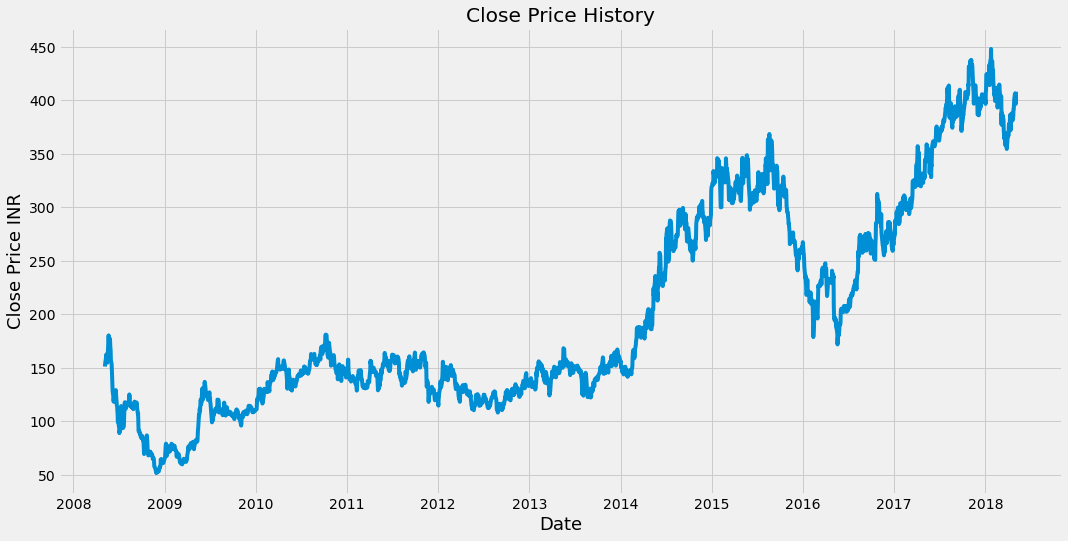

Epoch 1/5
64/64 [==============================] - 6s 38ms/step - loss: 0.0089
Epoch 2/5
64/64 [==============================] - 3s 47ms/step - loss: 6.2448e-04
Epoch 3/5
64/64 [==============================] - 3s 46ms/step - loss: 5.8343e-04
Epoch 4/5
64/64 [==============================] - 3s 44ms/step - loss: 5.8253e-04
Epoch 5/5
64/64 [==============================] - 3s 47ms/step - loss: 5.3031e-04
5.938259464434864


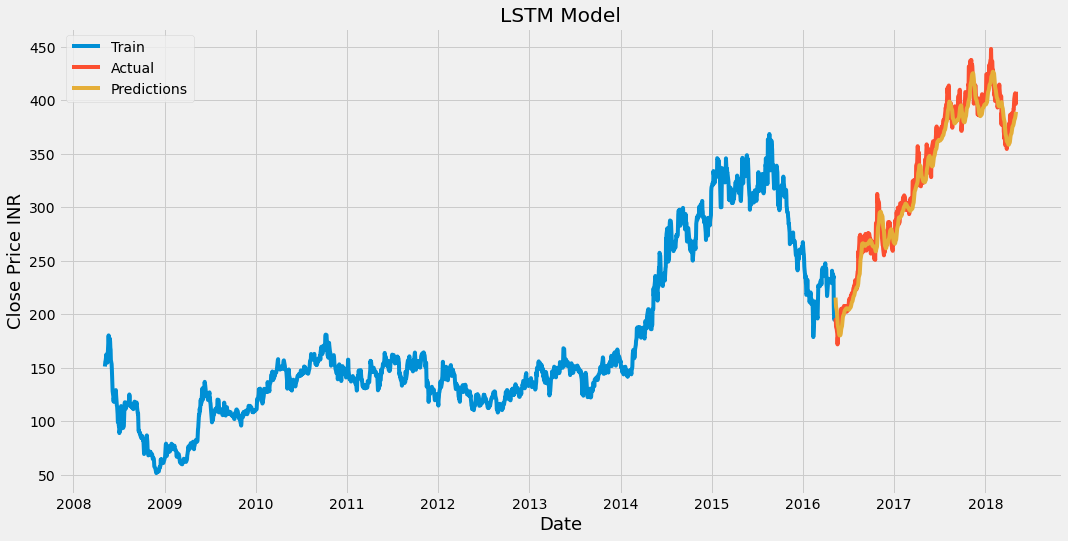

Predicted close Stock Price of the next day is 
 215.63653564453125,Actual is 193.300003


Stock Name: ASIANPAINT


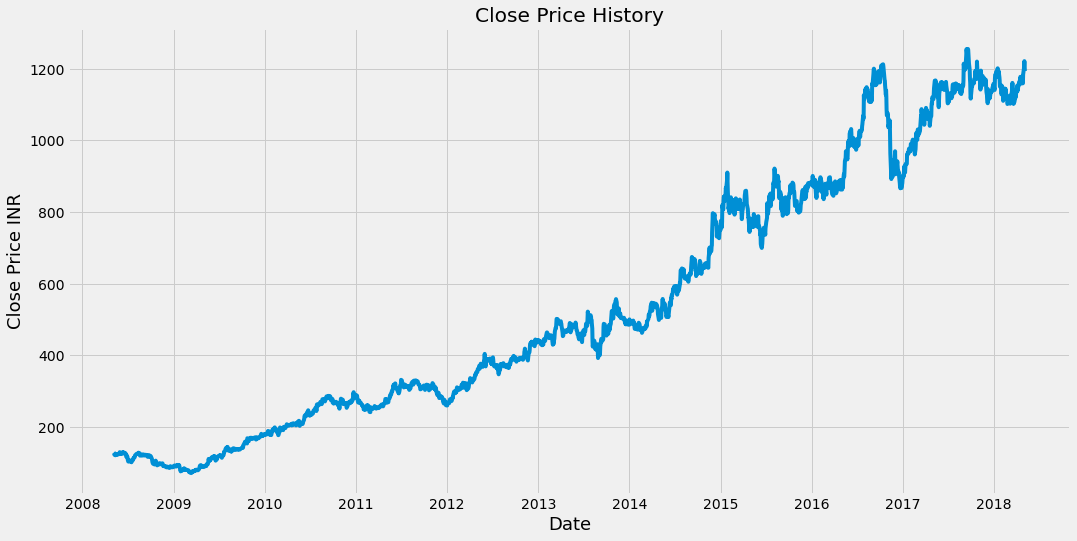

Epoch 1/5
64/64 [==============================] - 6s 51ms/step - loss: 0.0054
Epoch 2/5
64/64 [==============================] - 3s 47ms/step - loss: 2.1985e-04
Epoch 3/5
64/64 [==============================] - 3s 47ms/step - loss: 2.2535e-04
Epoch 4/5
64/64 [==============================] - 3s 51ms/step - loss: 2.2613e-04
Epoch 5/5
64/64 [==============================] - 3s 45ms/step - loss: 2.3995e-04
22.30351121308118


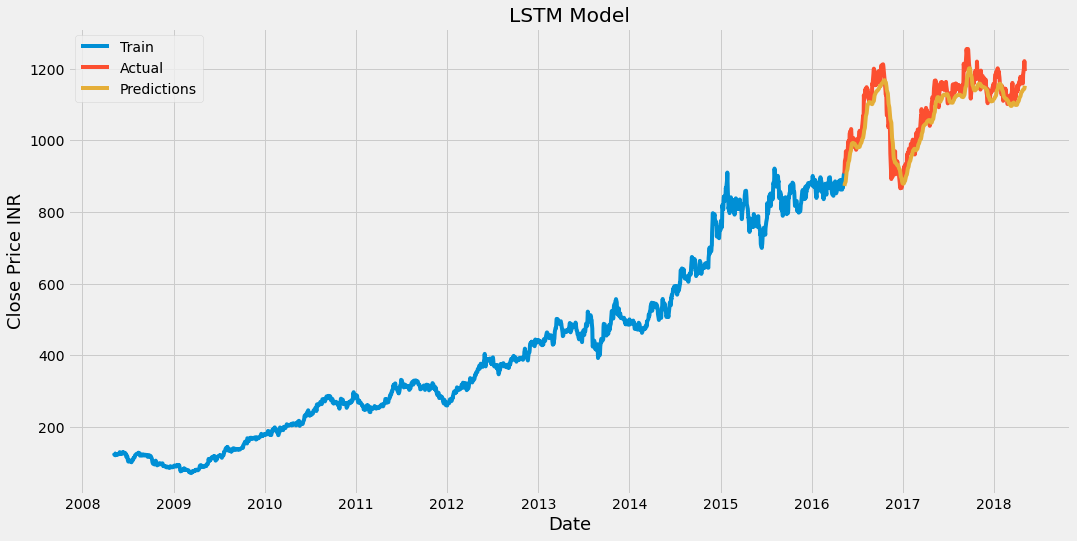

Predicted close Stock Price of the next day is 
 872.8787231445312,Actual is 907.400024


Stock Name: AXISBANK


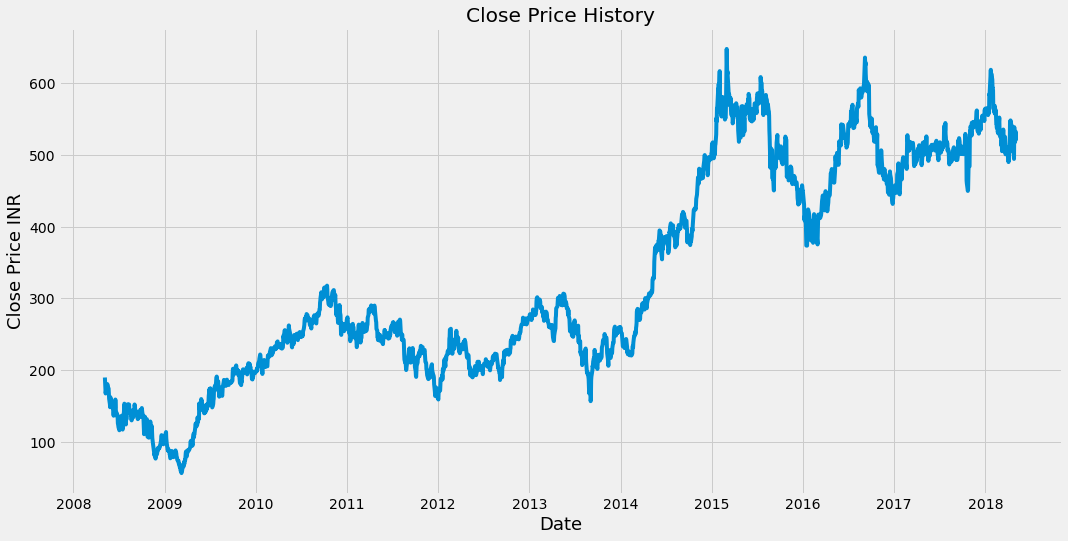

Epoch 1/5
64/64 [==============================] - 6s 41ms/step - loss: 0.0083
Epoch 2/5
64/64 [==============================] - 3s 44ms/step - loss: 6.3966e-04
Epoch 3/5
64/64 [==============================] - 3s 46ms/step - loss: 6.0916e-04
Epoch 4/5
64/64 [==============================] - 3s 46ms/step - loss: 6.2290e-04
Epoch 5/5
64/64 [==============================] - 3s 45ms/step - loss: 5.5983e-04
11.27795094089018


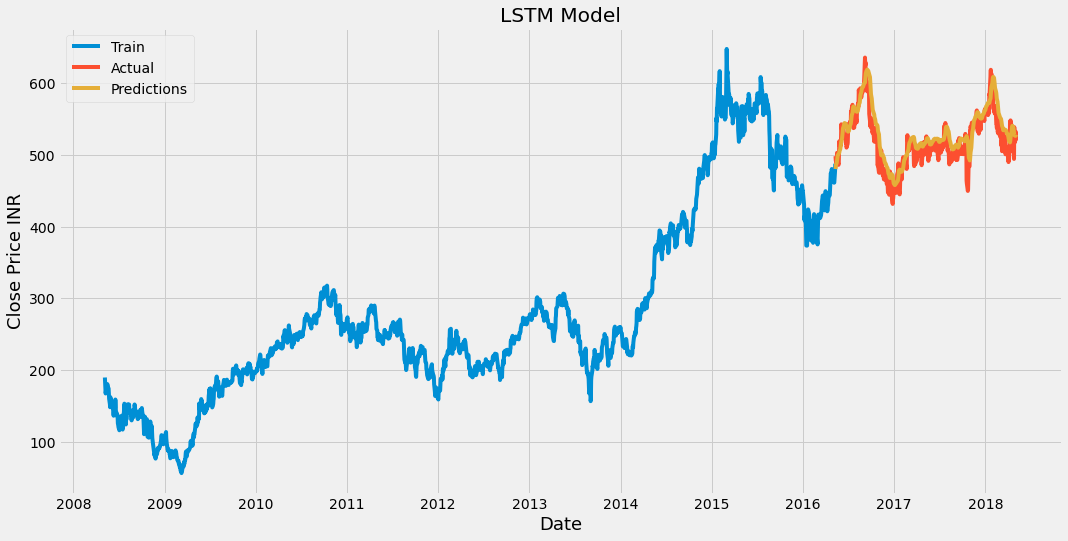

Predicted close Stock Price of the next day is 
 480.4407958984375,Actual is 498.399994


Stock Name: BAJAJ-AUTO


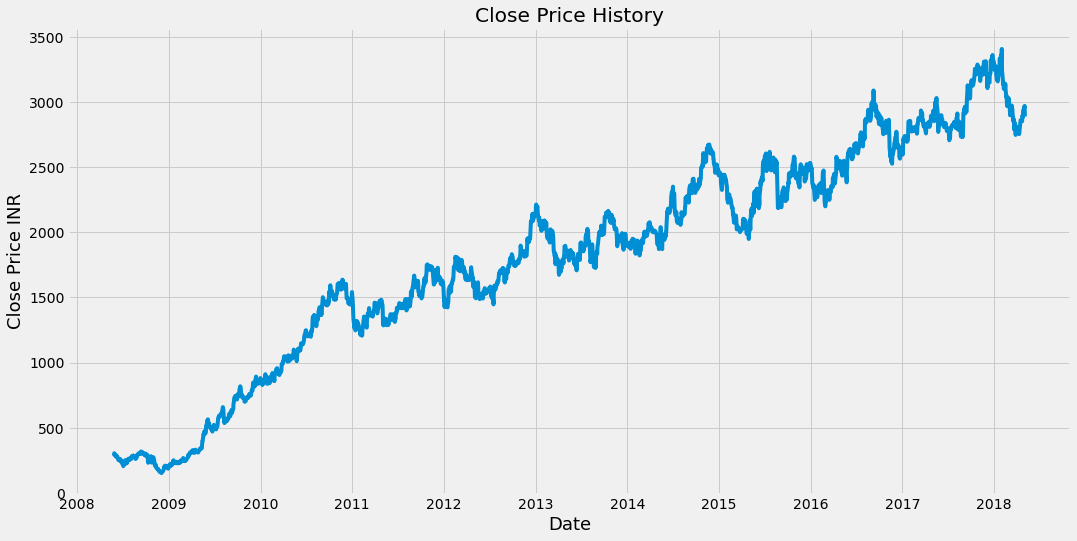

Epoch 1/5
64/64 [==============================] - 5s 43ms/step - loss: 0.0180
Epoch 2/5
64/64 [==============================] - 3s 47ms/step - loss: 4.1476e-04
Epoch 3/5
64/64 [==============================] - 3s 47ms/step - loss: 3.9011e-04
Epoch 4/5
64/64 [==============================] - 3s 45ms/step - loss: 3.9963e-04
Epoch 5/5
64/64 [==============================] - 3s 46ms/step - loss: 3.7460e-04
2.7535193315120106


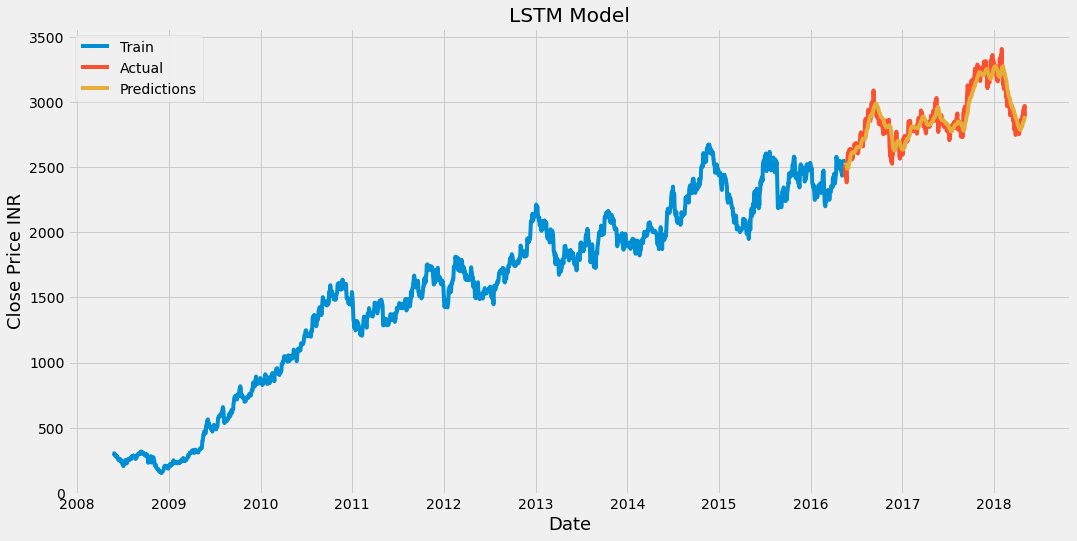

Predicted close Stock Price of the next day is 
 2517.074462890625,Actual is 2518.600098


Stock Name: BHARTIARTL


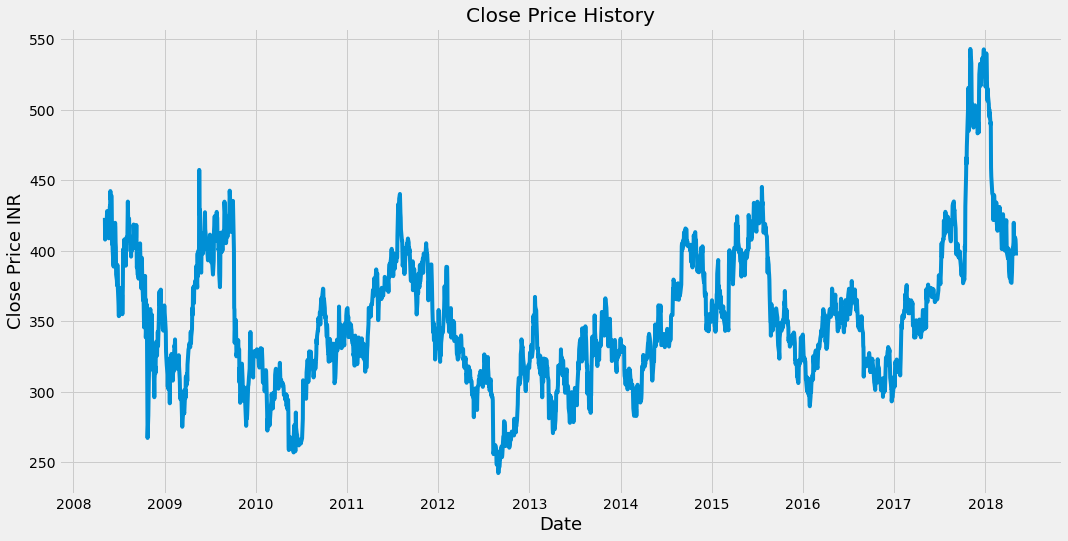

Epoch 1/5
64/64 [==============================] - 5s 44ms/step - loss: 0.0109
Epoch 2/5
64/64 [==============================] - 3s 47ms/step - loss: 0.0024
Epoch 3/5
64/64 [==============================] - 3s 44ms/step - loss: 0.0020
Epoch 4/5
64/64 [==============================] - 3s 46ms/step - loss: 0.0018
Epoch 5/5
64/64 [==============================] - 3s 50ms/step - loss: 0.0017
6.179609909576663


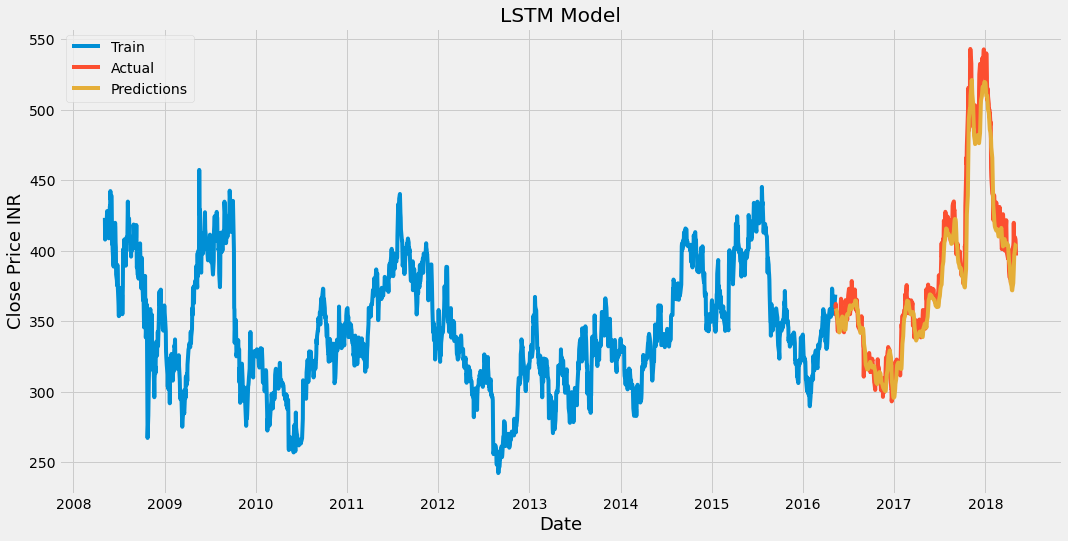

Predicted close Stock Price of the next day is 
 358.9405517578125,Actual is 359.450012


Stock Name: COALINDIA


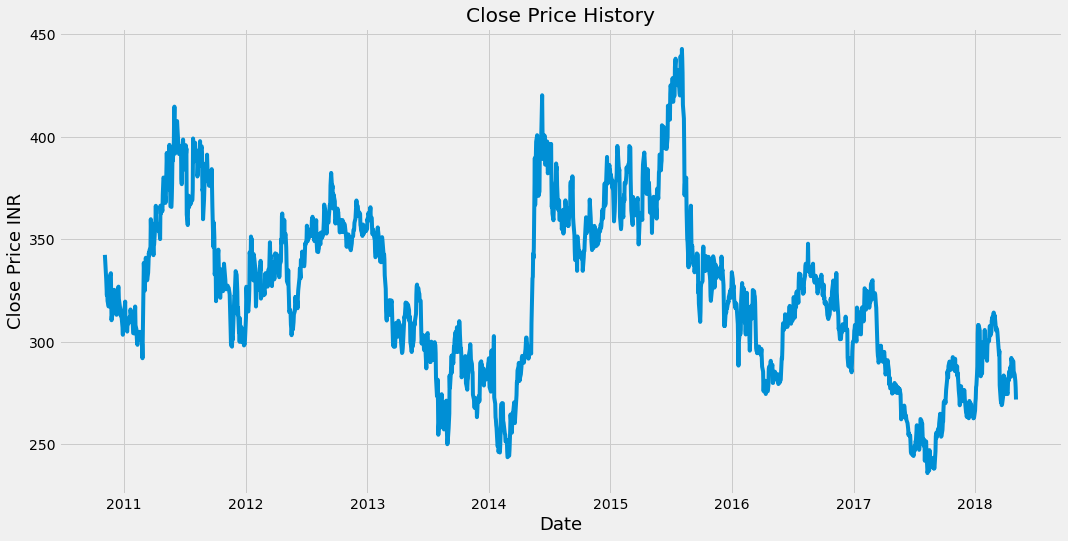

Epoch 1/5
48/48 [==============================] - 5s 45ms/step - loss: 0.0312
Epoch 2/5
48/48 [==============================] - 2s 48ms/step - loss: 0.0043
Epoch 3/5
48/48 [==============================] - 2s 47ms/step - loss: 0.0038
Epoch 4/5
48/48 [==============================] - 2s 48ms/step - loss: 0.0034
Epoch 5/5
48/48 [==============================] - 2s 47ms/step - loss: 0.0034
2.7591184757262024


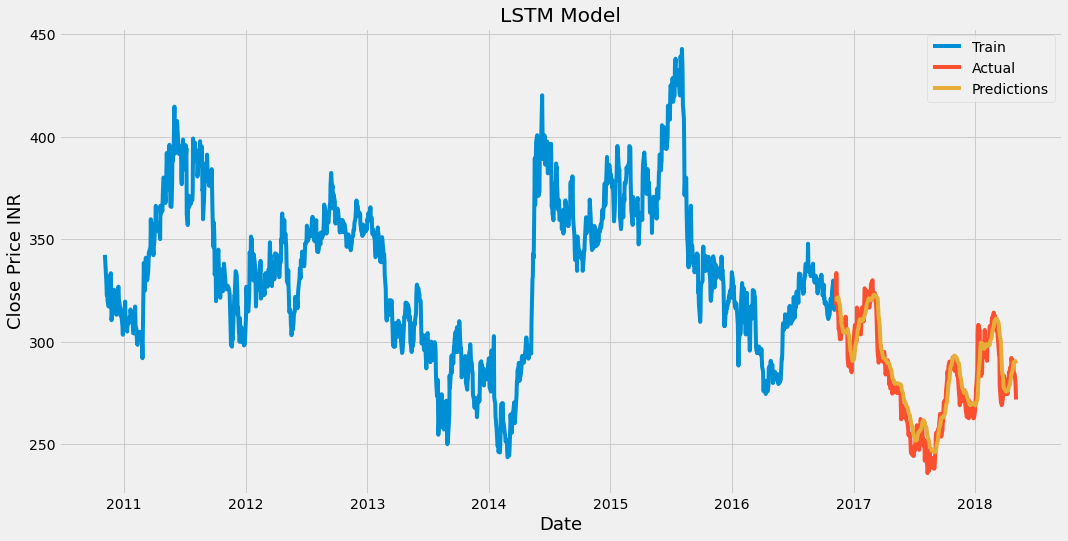

Predicted close Stock Price of the next day is 
 320.72613525390625,Actual is 317.899994


Stock Name: DRREDDY


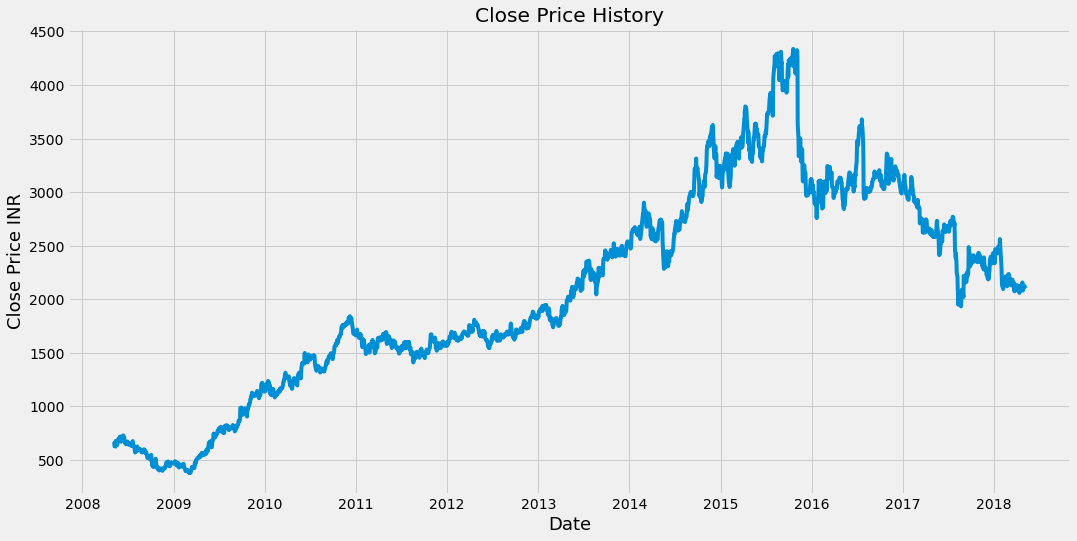

Epoch 1/5
64/64 [==============================] - 5s 46ms/step - loss: 0.0136: 0s 
Epoch 2/5
64/64 [==============================] - 3s 48ms/step - loss: 5.6016e-04
Epoch 3/5
64/64 [==============================] - 3s 43ms/step - loss: 5.2340e-04
Epoch 4/5
64/64 [==============================] - 3s 45ms/step - loss: 5.6137e-04
Epoch 5/5
64/64 [==============================] - 3s 47ms/step - loss: 5.3400e-04
31.494602864932666


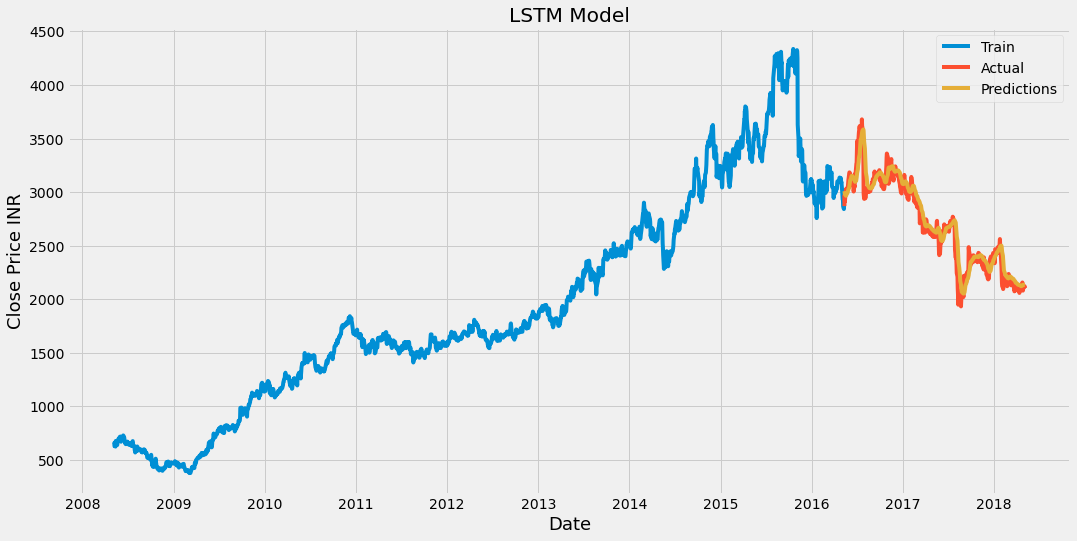

Predicted close Stock Price of the next day is 
 3009.2451171875,Actual is 2869.199951


Stock Name: HDFC


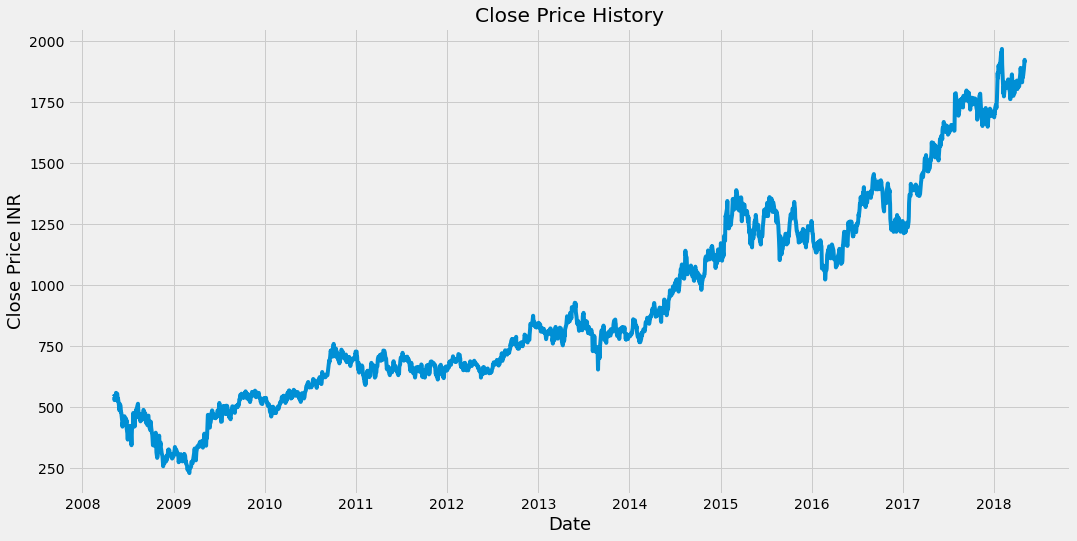

Epoch 1/5
64/64 [==============================] - 5s 43ms/step - loss: 0.0083
Epoch 2/5
64/64 [==============================] - 3s 46ms/step - loss: 3.3615e-04
Epoch 3/5
64/64 [==============================] - 3s 47ms/step - loss: 3.3260e-04
Epoch 4/5
64/64 [==============================] - 3s 47ms/step - loss: 3.2002e-04
Epoch 5/5
64/64 [==============================] - 3s 46ms/step - loss: 3.3092e-04
40.74575061860073


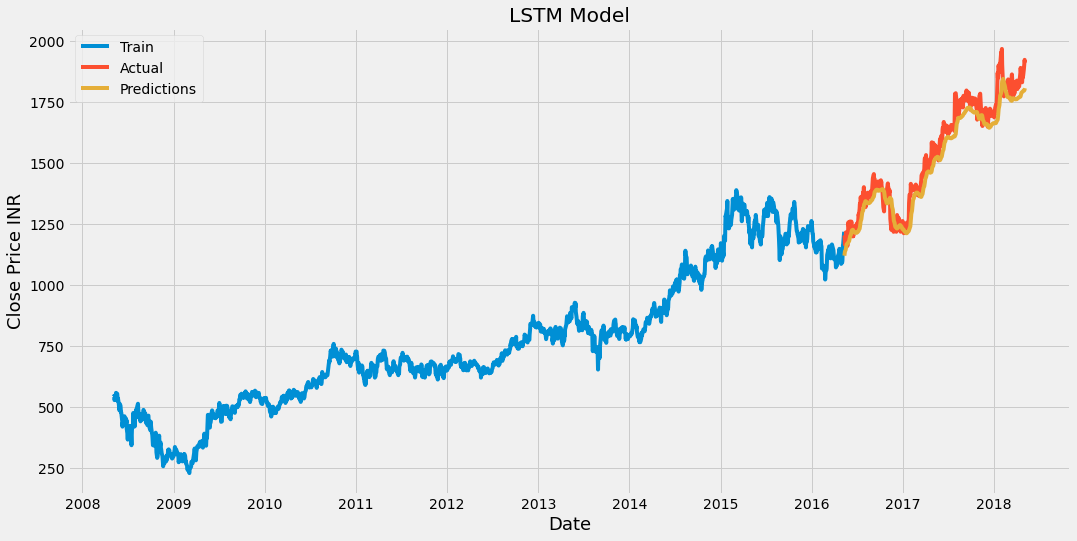

Predicted close Stock Price of the next day is 
 1120.618408203125,Actual is 1203.650024


Stock Name: HDFCBANK


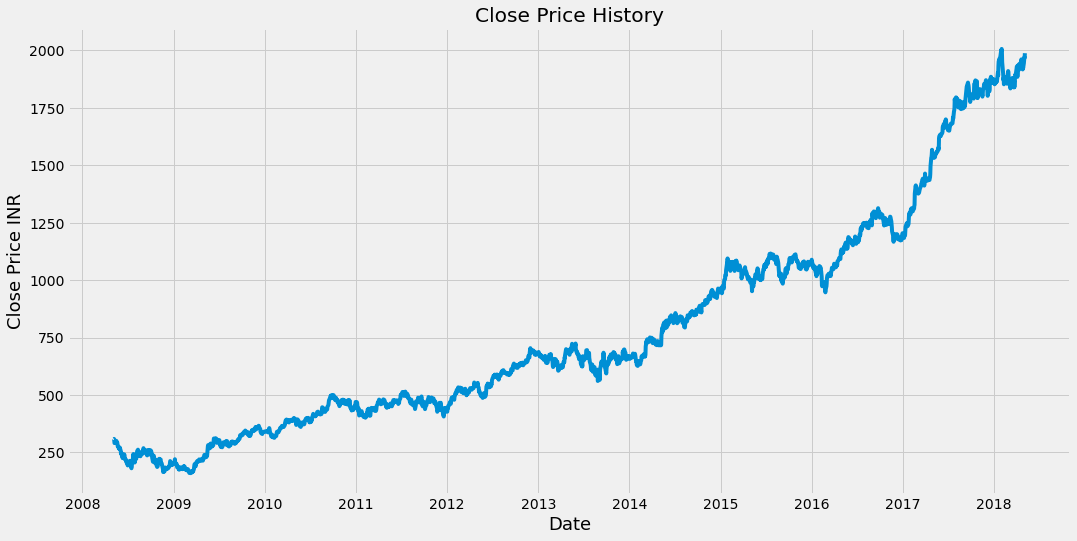

Epoch 1/5
64/64 [==============================] - 6s 45ms/step - loss: 0.0042: 0s - lo
Epoch 2/5
64/64 [==============================] - 3s 49ms/step - loss: 1.3689e-04
Epoch 3/5
64/64 [==============================] - 3s 51ms/step - loss: 1.2604e-04
Epoch 4/5
64/64 [==============================] - 3s 48ms/step - loss: 1.2567e-04
Epoch 5/5
64/64 [==============================] - 3s 49ms/step - loss: 1.2028e-04: 
52.122500042381226


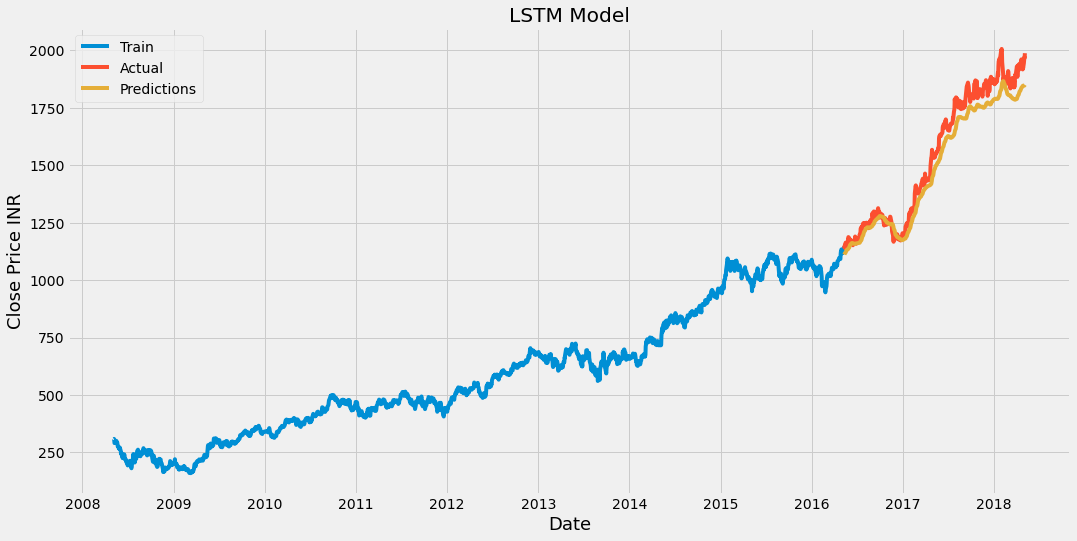

Predicted close Stock Price of the next day is 
 1110.8172607421875,Actual is 1138.0


Stock Name: HEROMOTOCO


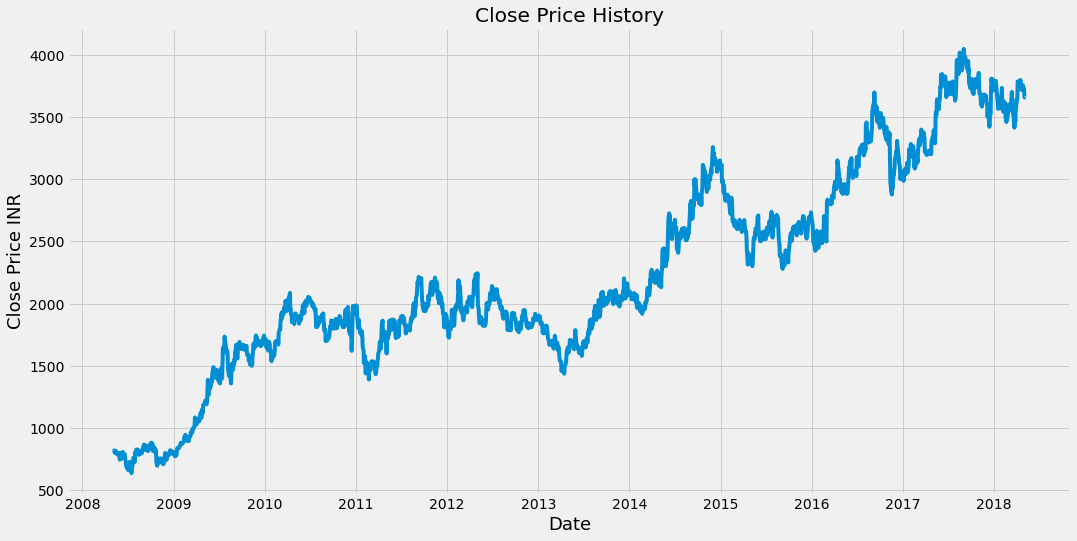

Epoch 1/5
64/64 [==============================] - 5s 45ms/step - loss: 0.0083
Epoch 2/5
64/64 [==============================] - 3s 48ms/step - loss: 5.8332e-04
Epoch 3/5
64/64 [==============================] - 3s 46ms/step - loss: 5.5444e-04
Epoch 4/5
64/64 [==============================] - 3s 48ms/step - loss: 5.3869e-04
Epoch 5/5
64/64 [==============================] - 3s 46ms/step - loss: 4.9776e-04
54.582212385607214


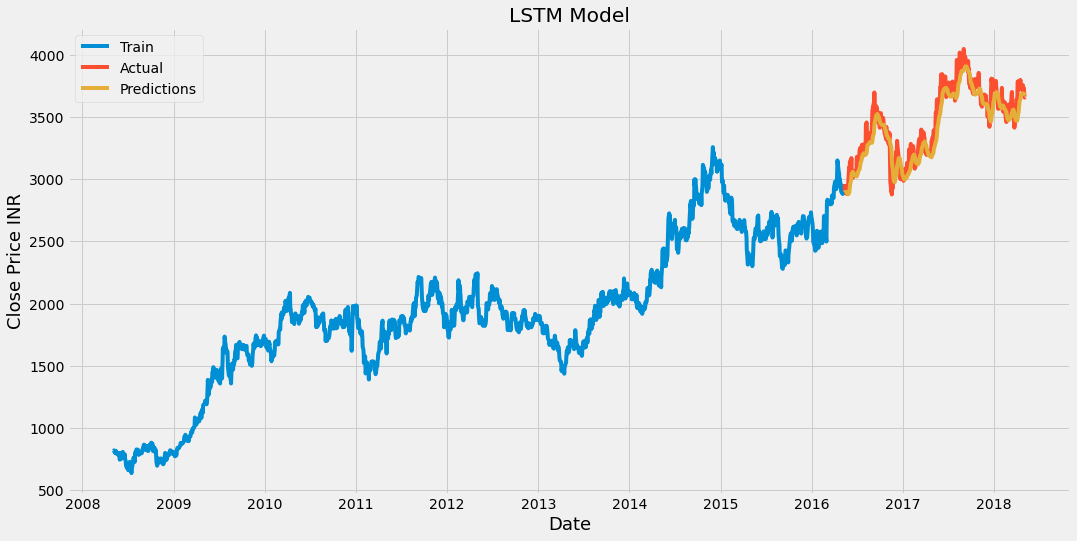

Predicted close Stock Price of the next day is 
 2893.832275390625,Actual is 2960.649902


Stock Name: HINDUNILVR


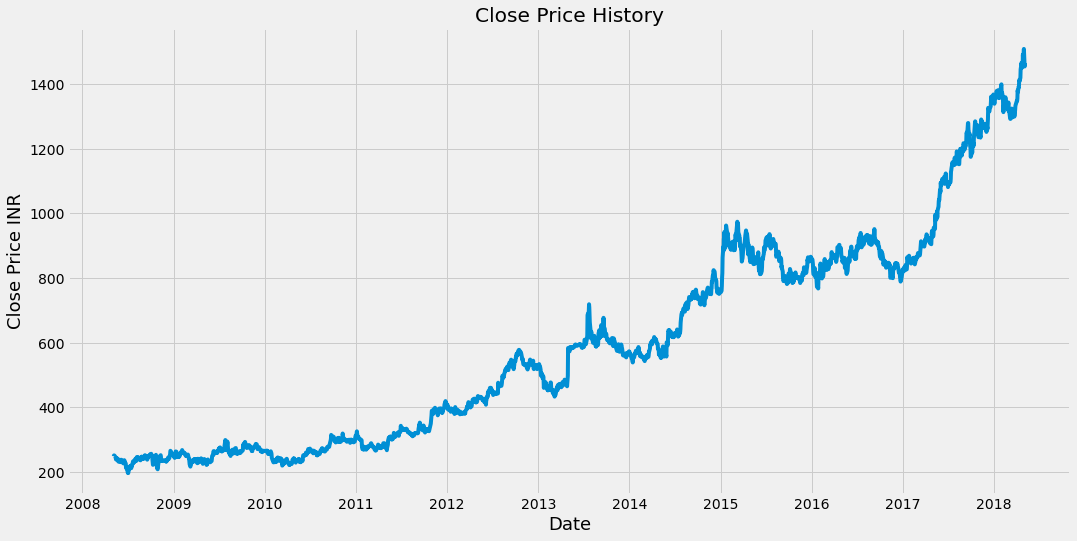

Epoch 1/5
64/64 [==============================] - 5s 43ms/step - loss: 0.0036: 1s 
Epoch 2/5
64/64 [==============================] - 3s 44ms/step - loss: 2.4326e-04
Epoch 3/5
64/64 [==============================] - 3s 44ms/step - loss: 2.3883e-04
Epoch 4/5
64/64 [==============================] - 3s 45ms/step - loss: 2.1837e-04
Epoch 5/5
64/64 [==============================] - 3s 41ms/step - loss: 2.0268e-04
0.1934227750015881


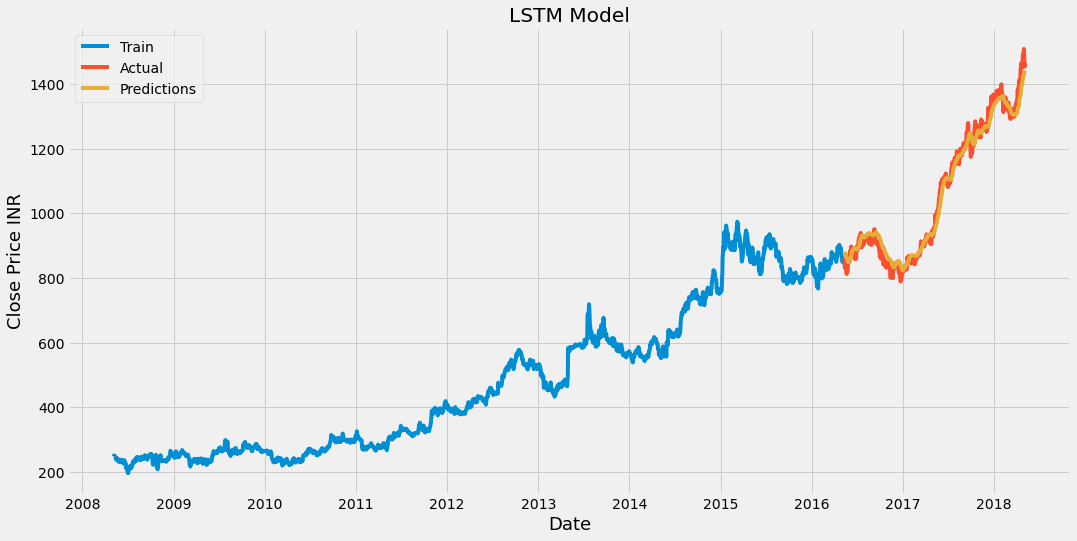

Predicted close Stock Price of the next day is 
 880.9915161132812,Actual is 862.700012


Stock Name: ICICIBANK


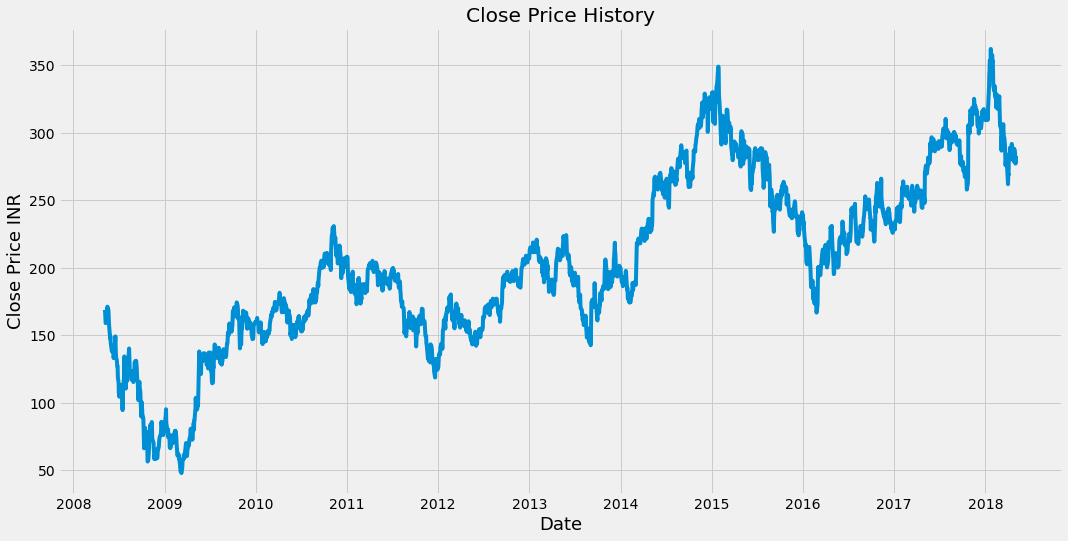

Epoch 1/5
64/64 [==============================] - 5s 48ms/step - loss: 0.0082
Epoch 2/5
64/64 [==============================] - 3s 48ms/step - loss: 8.3572e-04
Epoch 3/5
64/64 [==============================] - 3s 48ms/step - loss: 8.0524e-04
Epoch 4/5
64/64 [==============================] - 3s 47ms/step - loss: 7.7978e-04
Epoch 5/5
64/64 [==============================] - 3s 48ms/step - loss: 7.6073e-04
5.037314007169399


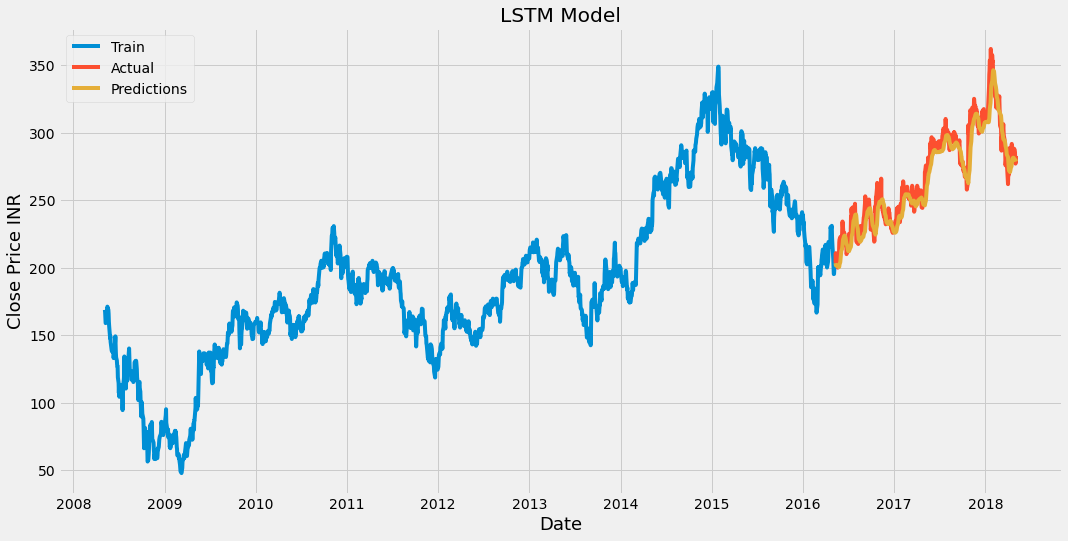

Predicted close Stock Price of the next day is 
 203.36627197265625,Actual is 203.727005


Stock Name: INDUSINDBK


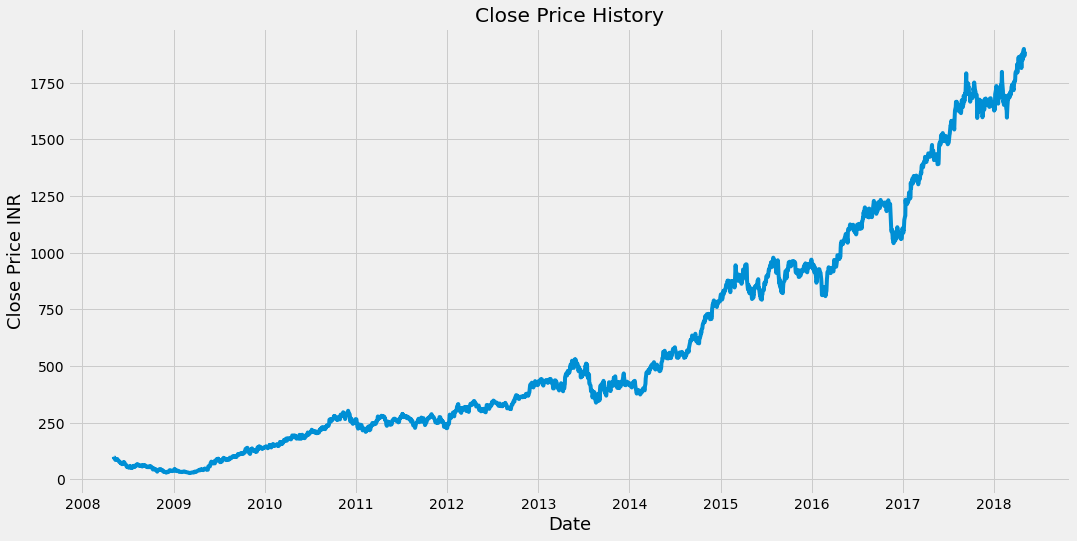

Epoch 1/5
64/64 [==============================] - 6s 45ms/step - loss: 0.0020
Epoch 2/5
64/64 [==============================] - 3s 48ms/step - loss: 1.1990e-04
Epoch 3/5
64/64 [==============================] - 3s 46ms/step - loss: 1.1748e-04
Epoch 4/5
64/64 [==============================] - 3s 46ms/step - loss: 1.2367e-04
Epoch 5/5
64/64 [==============================] - 3s 47ms/step - loss: 1.2641e-04
39.44631077223863


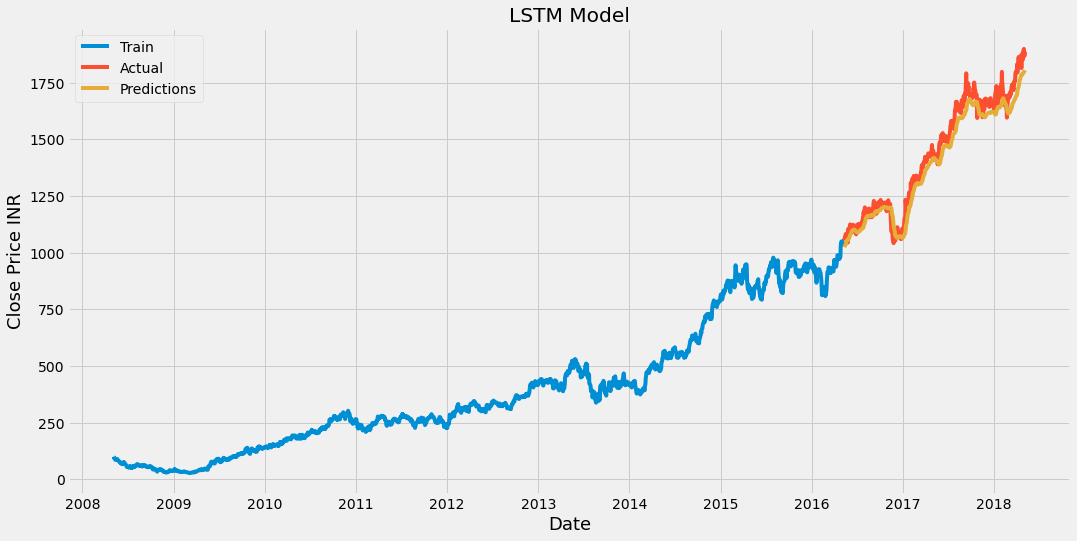

Predicted close Stock Price of the next day is 
 1023.6333618164062,Actual is 1053.300049


Stock Name: INFY


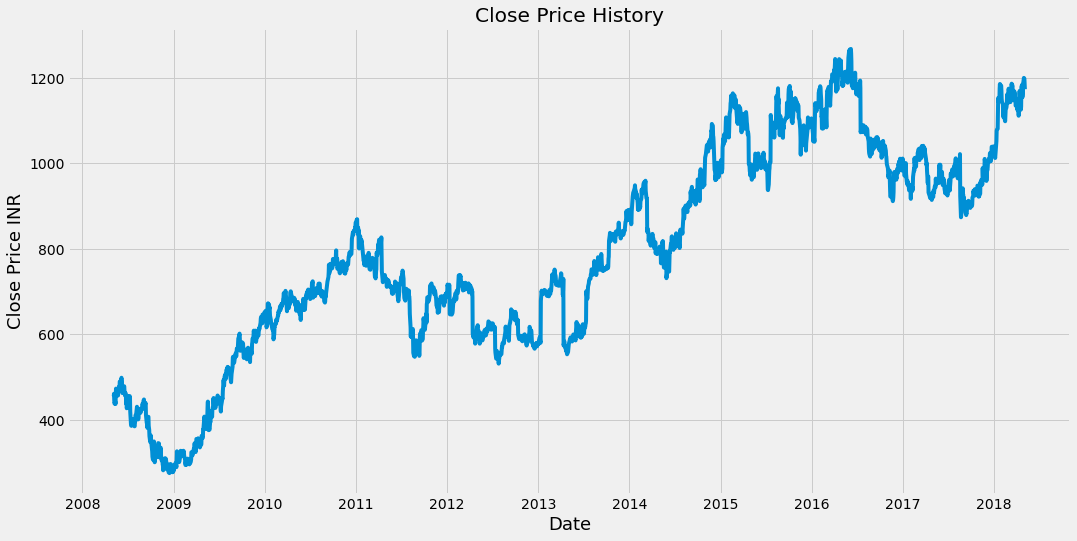

Epoch 1/5
64/64 [==============================] - 6s 49ms/step - loss: 0.0140
Epoch 2/5
64/64 [==============================] - 3s 51ms/step - loss: 9.6026e-04
Epoch 3/5
64/64 [==============================] - 3s 49ms/step - loss: 9.1925e-04
Epoch 4/5
64/64 [==============================] - 3s 49ms/step - loss: 8.9559e-04
Epoch 5/5
64/64 [==============================] - 3s 48ms/step - loss: 8.2142e-04
28.000096764545223


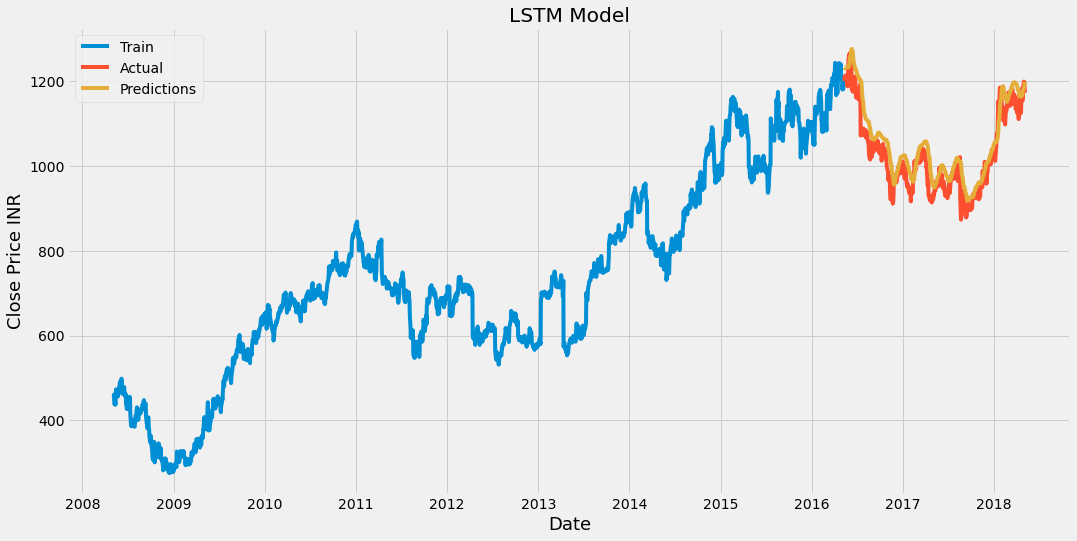

Predicted close Stock Price of the next day is 
 1232.069091796875,Actual is 1201.050049


Stock Name: ITC


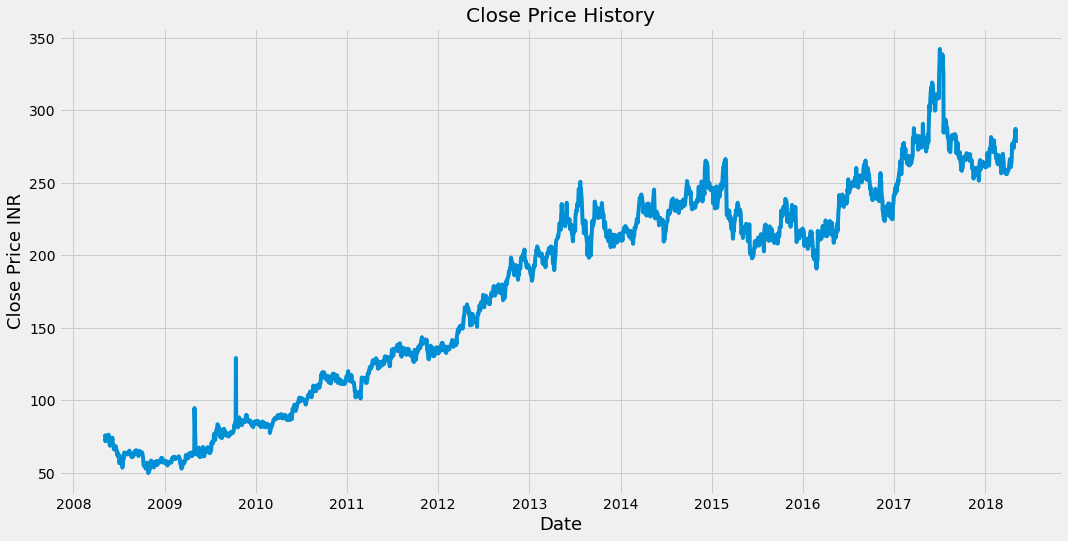

Epoch 1/5
64/64 [==============================] - 5s 45ms/step - loss: 0.0104
Epoch 2/5
64/64 [==============================] - 3s 45ms/step - loss: 4.3398e-04
Epoch 3/5
64/64 [==============================] - 3s 46ms/step - loss: 4.2439e-04
Epoch 4/5
64/64 [==============================] - 3s 48ms/step - loss: 4.5888e-04
Epoch 5/5
64/64 [==============================] - 3s 44ms/step - loss: 4.3576e-04
4.950621375309642


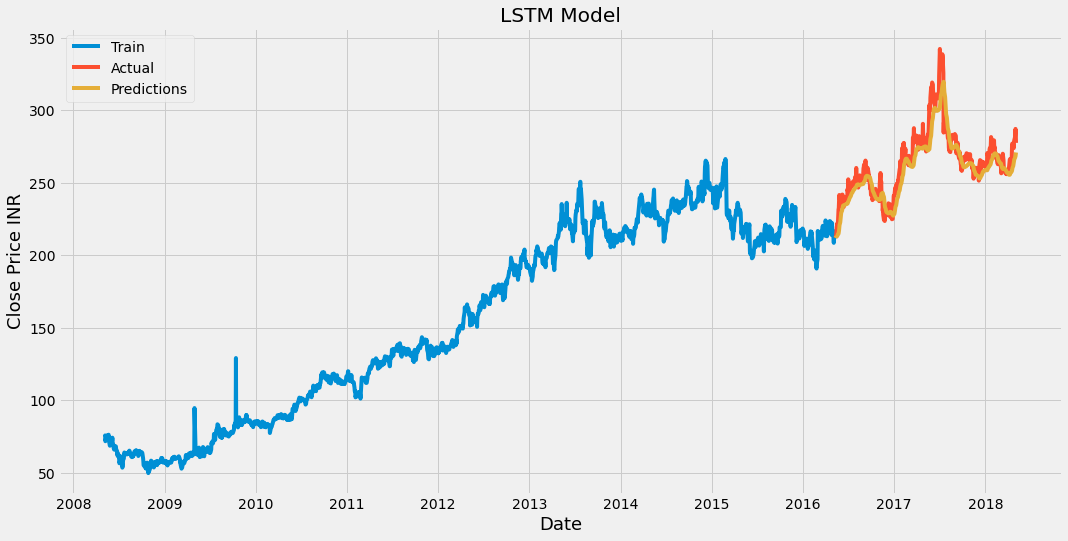

Predicted close Stock Price of the next day is 
 213.74490356445312,Actual is 212.0


Stock Name: KOTAKBANK


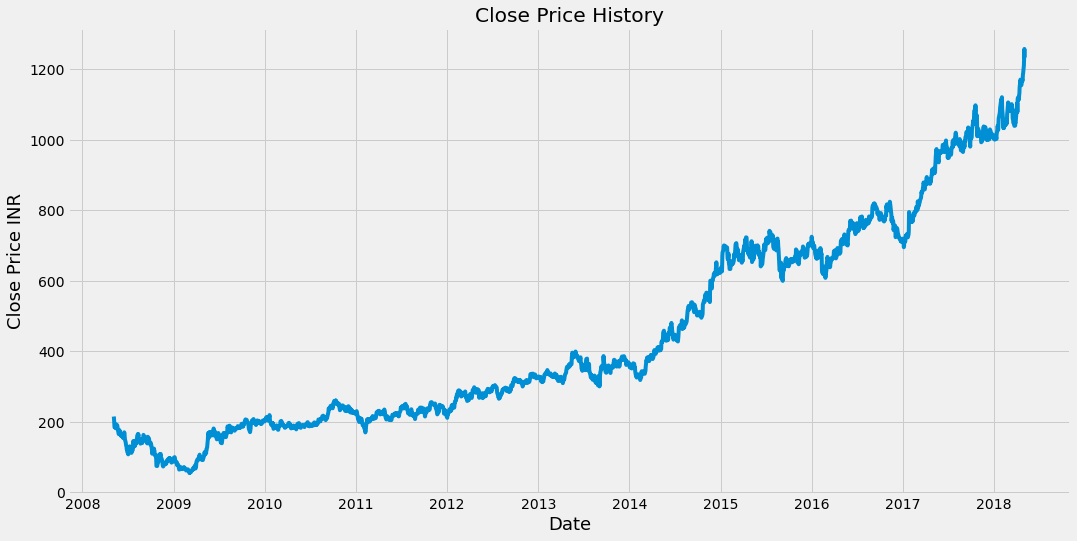

Epoch 1/5
64/64 [==============================] - 6s 46ms/step - loss: 0.0044: 0s - loss: 0.006 - ETA: 0s
Epoch 2/5
64/64 [==============================] - 3s 48ms/step - loss: 1.8001e-04
Epoch 3/5
64/64 [==============================] - 3s 50ms/step - loss: 1.6614e-04
Epoch 4/5
64/64 [==============================] - 3s 48ms/step - loss: 1.5947e-04
Epoch 5/5
64/64 [==============================] - 3s 50ms/step - loss: 1.7974e-04
52.994513670477644


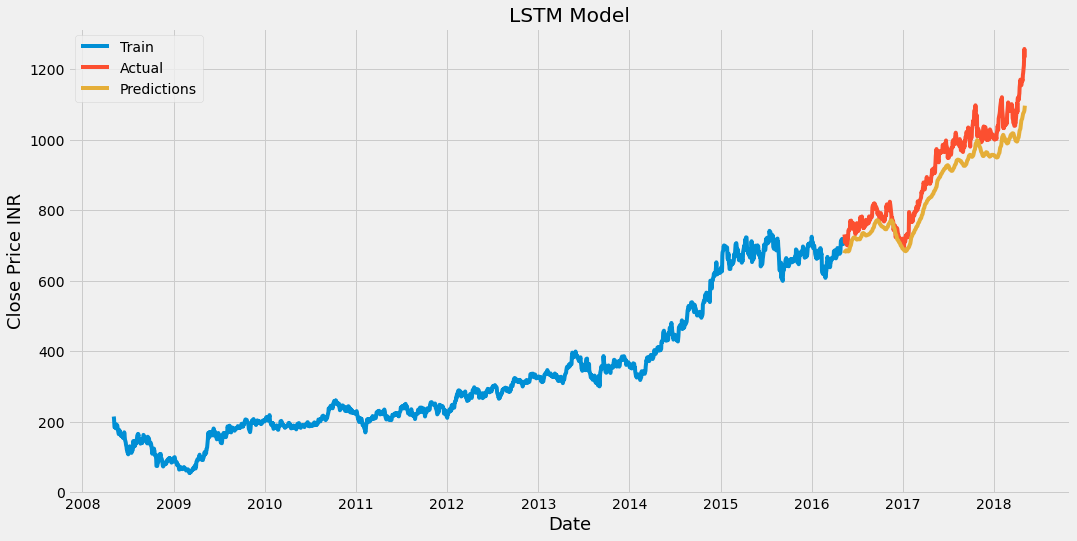

Predicted close Stock Price of the next day is 
 677.8251342773438,Actual is 731.150024


Stock Name: LT


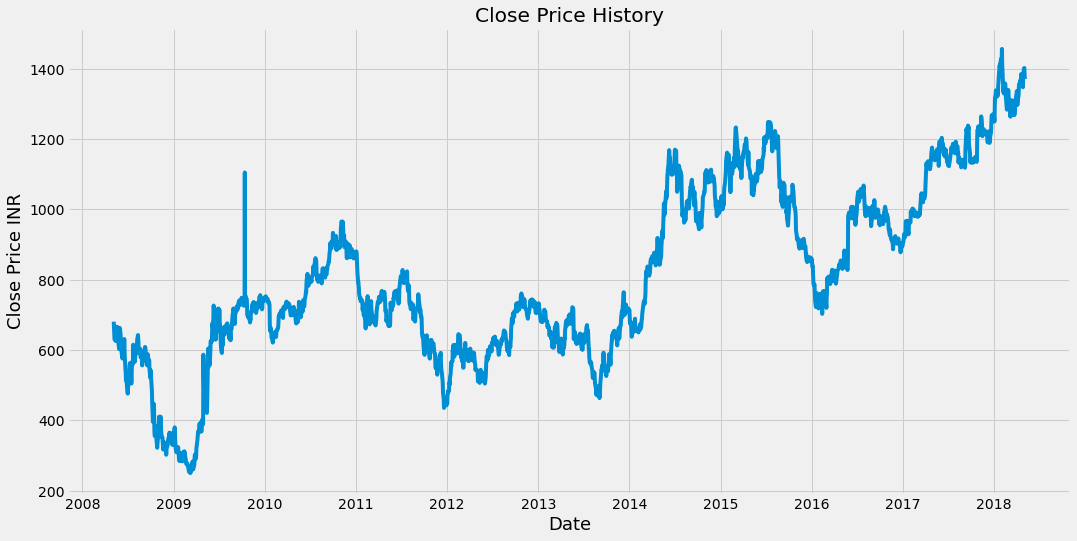

Epoch 1/5
64/64 [==============================] - 6s 49ms/step - loss: 0.0112
Epoch 2/5
64/64 [==============================] - 3s 51ms/step - loss: 0.0011
Epoch 3/5
64/64 [==============================] - 3s 51ms/step - loss: 0.0010
Epoch 4/5
64/64 [==============================] - 3s 49ms/step - loss: 9.1120e-04
Epoch 5/5
64/64 [==============================] - 3s 52ms/step - loss: 8.9834e-04
6.990886905019371


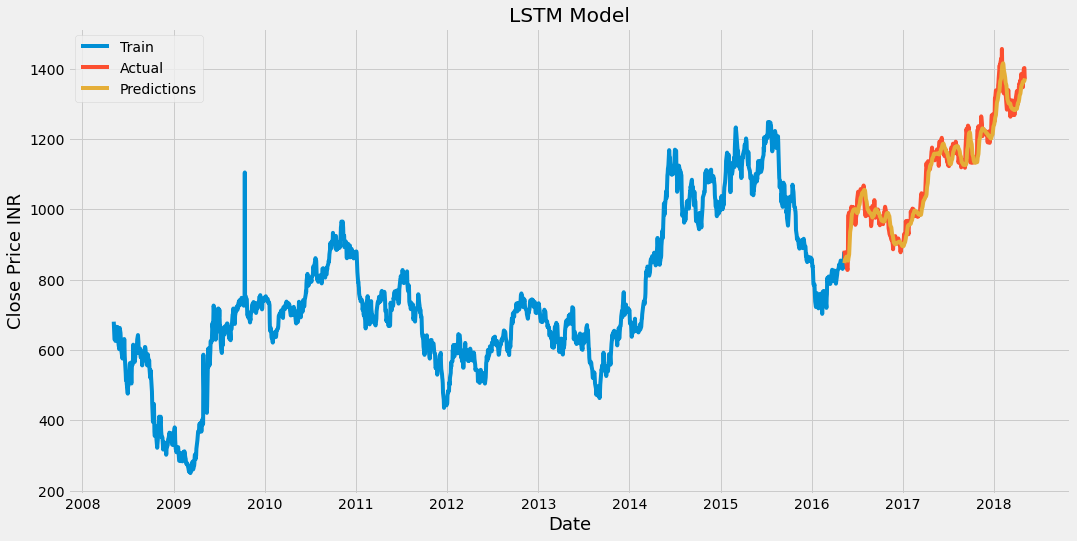

Predicted close Stock Price of the next day is 
 846.7249755859375,Actual is 882.666992


Stock Name: M&M


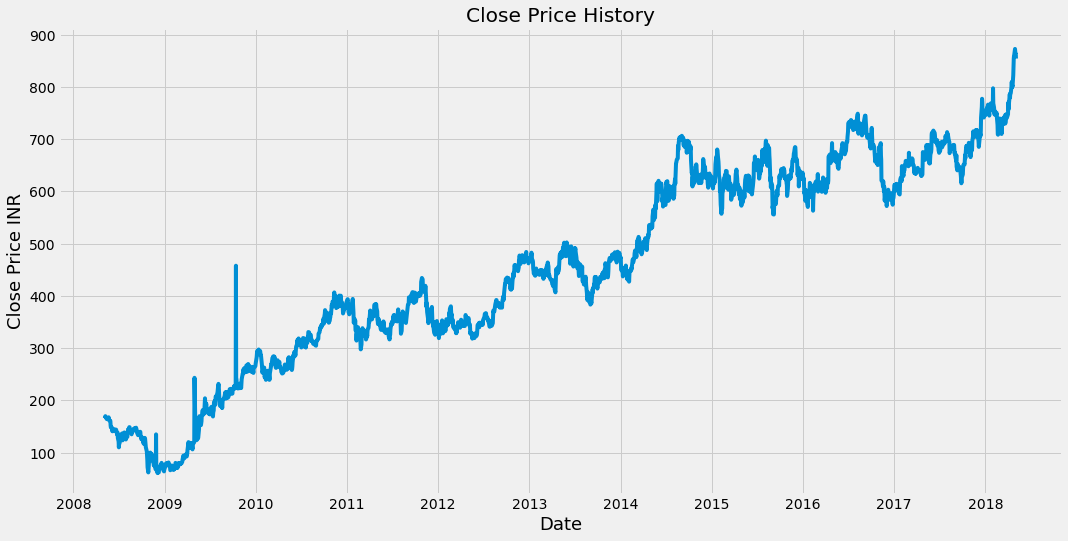

Epoch 1/5
64/64 [==============================] - 6s 45ms/step - loss: 0.0177
Epoch 2/5
64/64 [==============================] - 3s 49ms/step - loss: 5.3441e-04
Epoch 3/5
64/64 [==============================] - 3s 46ms/step - loss: 5.3417e-04
Epoch 4/5
64/64 [==============================] - 3s 47ms/step - loss: 5.3343e-04
Epoch 5/5
64/64 [==============================] - 3s 47ms/step - loss: 5.1195e-04
4.088627514124428


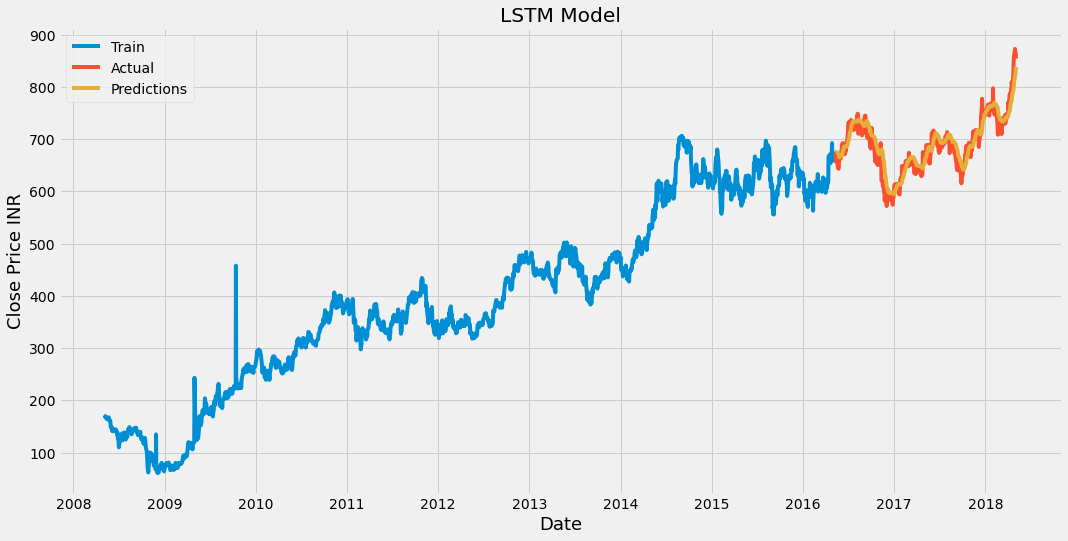

Predicted close Stock Price of the next day is 
 673.84033203125,Actual is 673.075012


Stock Name: MARUTI


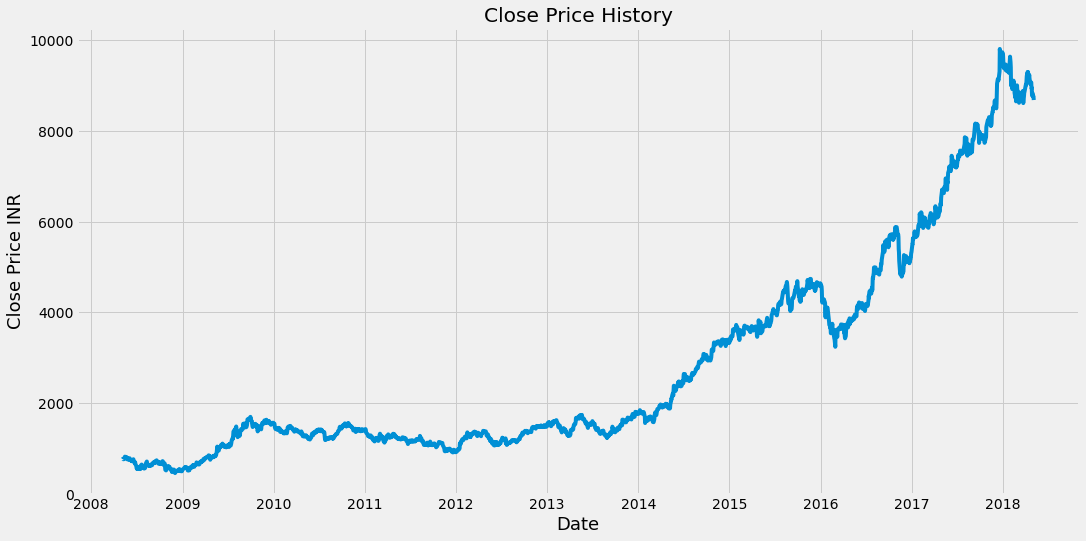

Epoch 1/5
64/64 [==============================] - 5s 41ms/step - loss: 0.0025
Epoch 2/5
64/64 [==============================] - 3s 46ms/step - loss: 1.0008e-04
Epoch 3/5
64/64 [==============================] - 3s 42ms/step - loss: 9.3028e-05
Epoch 4/5
64/64 [==============================] - 3s 46ms/step - loss: 9.3900e-05
Epoch 5/5
64/64 [==============================] - 3s 42ms/step - loss: 9.7123e-05
215.90841799583967


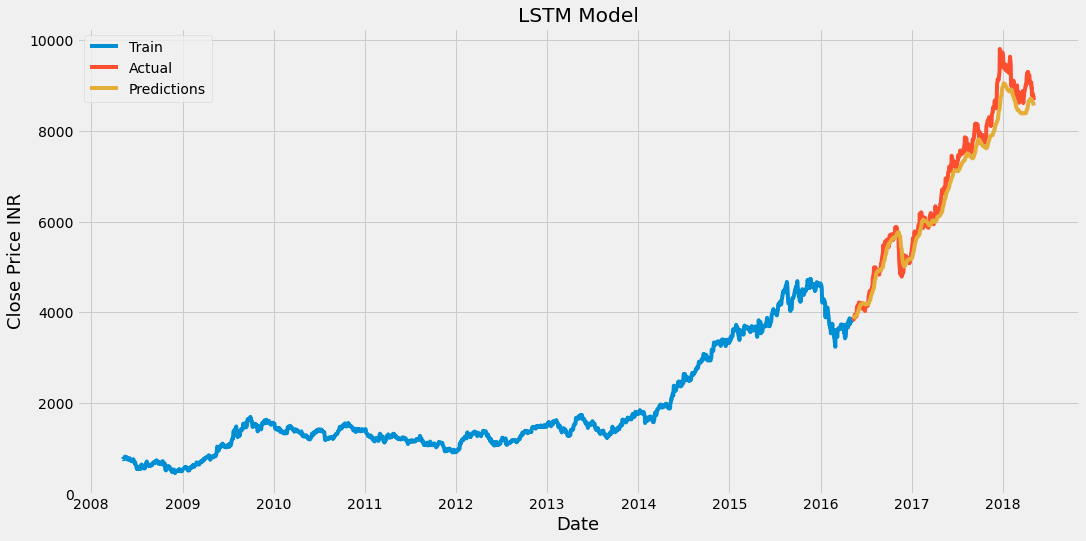

Predicted close Stock Price of the next day is 
 3862.08837890625,Actual is 3889.850098


Stock Name: ONGC


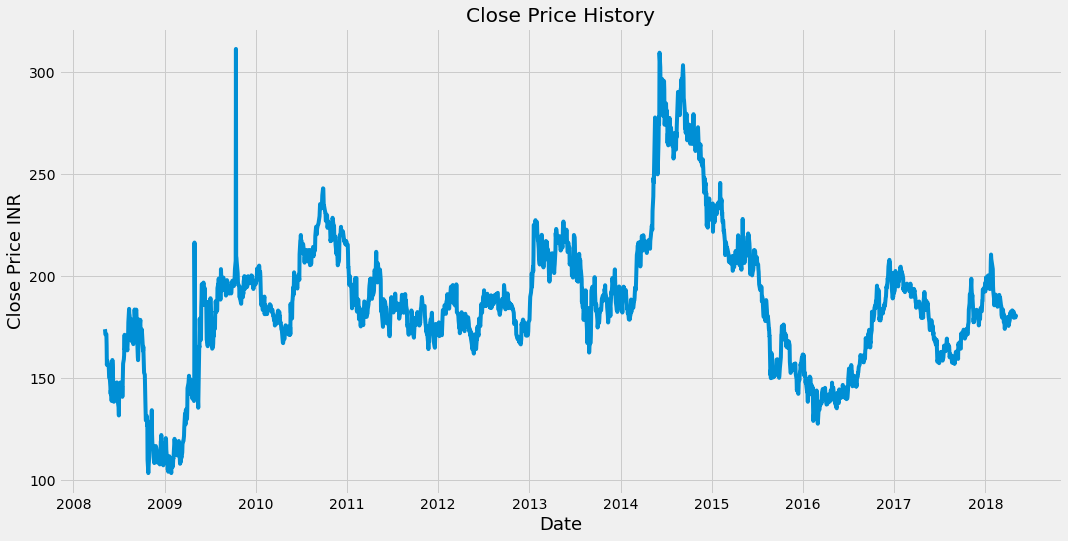

Epoch 1/5
64/64 [==============================] - 5s 45ms/step - loss: 0.0115
Epoch 2/5
64/64 [==============================] - 3s 47ms/step - loss: 0.0020
Epoch 3/5
64/64 [==============================] - 3s 48ms/step - loss: 0.0018
Epoch 4/5
64/64 [==============================] - 3s 49ms/step - loss: 0.0016
Epoch 5/5
64/64 [==============================] - 3s 46ms/step - loss: 0.0016
1.4907529301221891


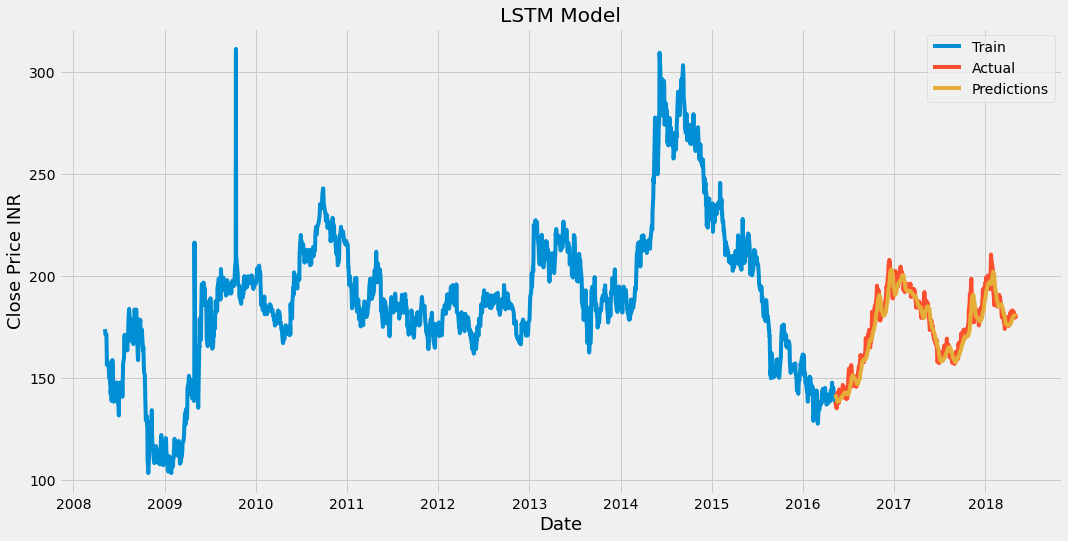

Predicted close Stock Price of the next day is 
 142.05758666992188,Actual is 137.100006


Stock Name: POWERGRID


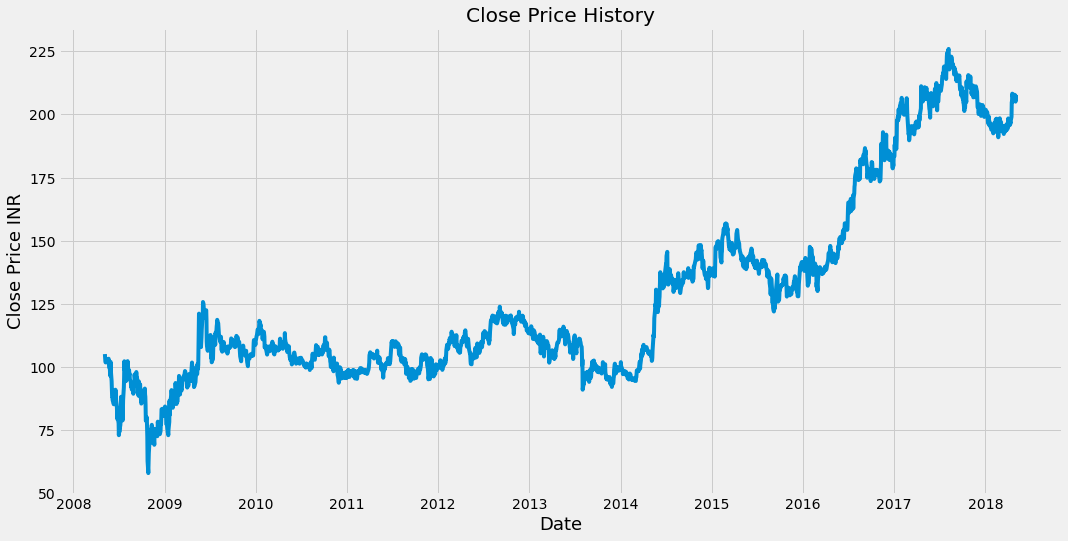

Epoch 1/5
64/64 [==============================] - 6s 48ms/step - loss: 0.0091
Epoch 2/5
64/64 [==============================] - 3s 52ms/step - loss: 5.5101e-04
Epoch 3/5
64/64 [==============================] - 4s 57ms/step - loss: 5.2287e-04
Epoch 4/5
64/64 [==============================] - 3s 52ms/step - loss: 5.0987e-04
Epoch 5/5
64/64 [==============================] - 3s 53ms/step - loss: 4.9237e-04
4.058662598529598


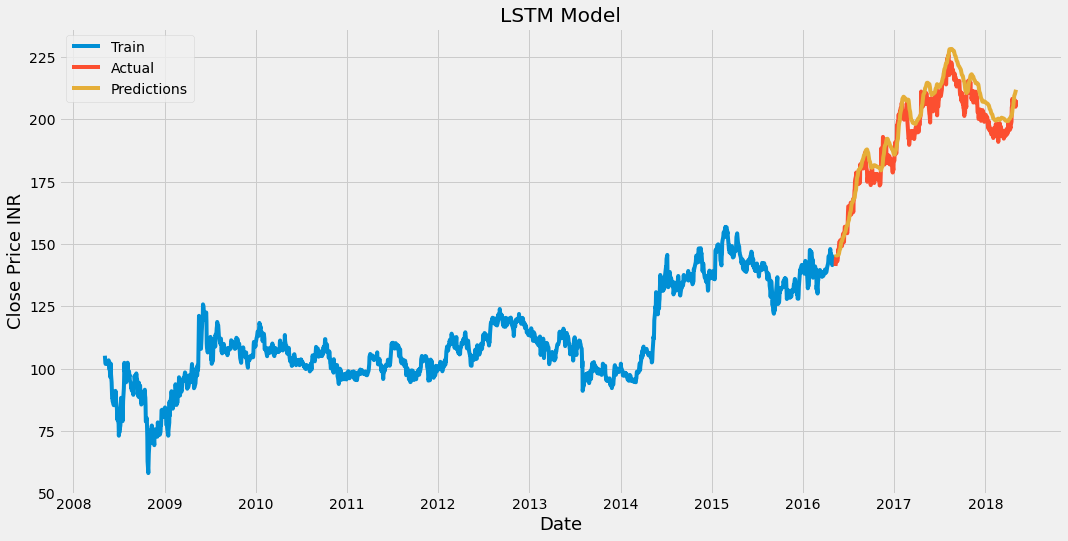

Predicted close Stock Price of the next day is 
 145.8404998779297,Actual is 141.149994


Stock Name: RELIANCE


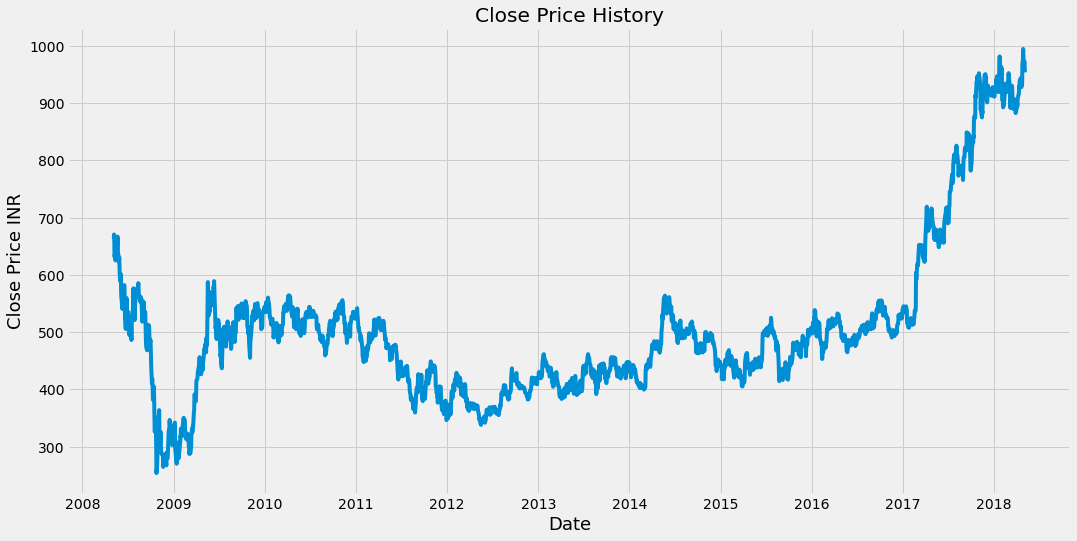

Epoch 1/5
64/64 [==============================] - 6s 47ms/step - loss: 0.0036
Epoch 2/5
64/64 [==============================] - 3s 50ms/step - loss: 6.9041e-04
Epoch 3/5
64/64 [==============================] - 3s 51ms/step - loss: 6.2690e-04
Epoch 4/5
64/64 [==============================] - 3s 50ms/step - loss: 5.5981e-04
Epoch 5/5
64/64 [==============================] - 3s 48ms/step - loss: 5.5393e-04
24.094891501036106


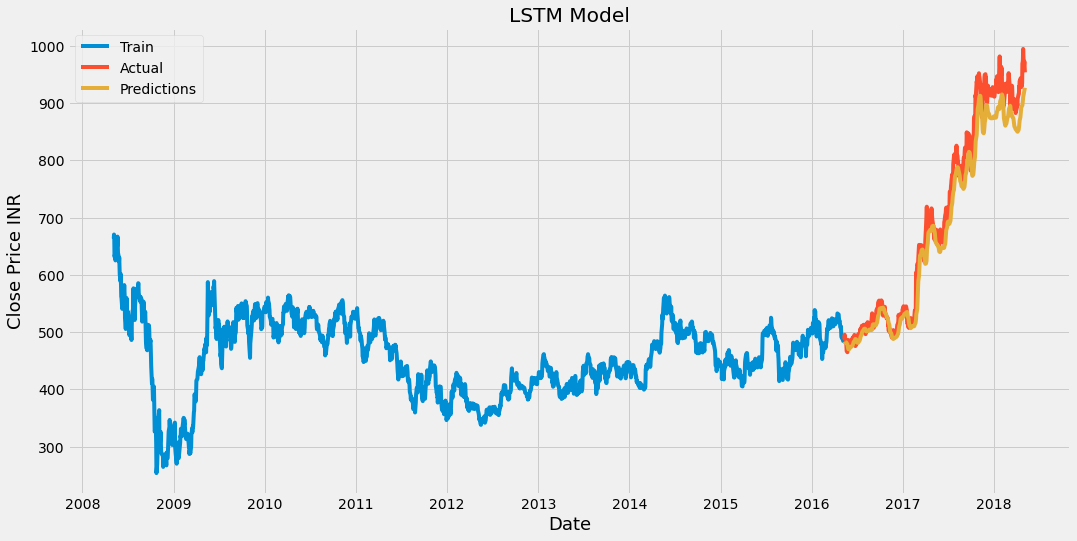

Predicted close Stock Price of the next day is 
 483.5892028808594,Actual is 487.424988


Stock Name: SBIN


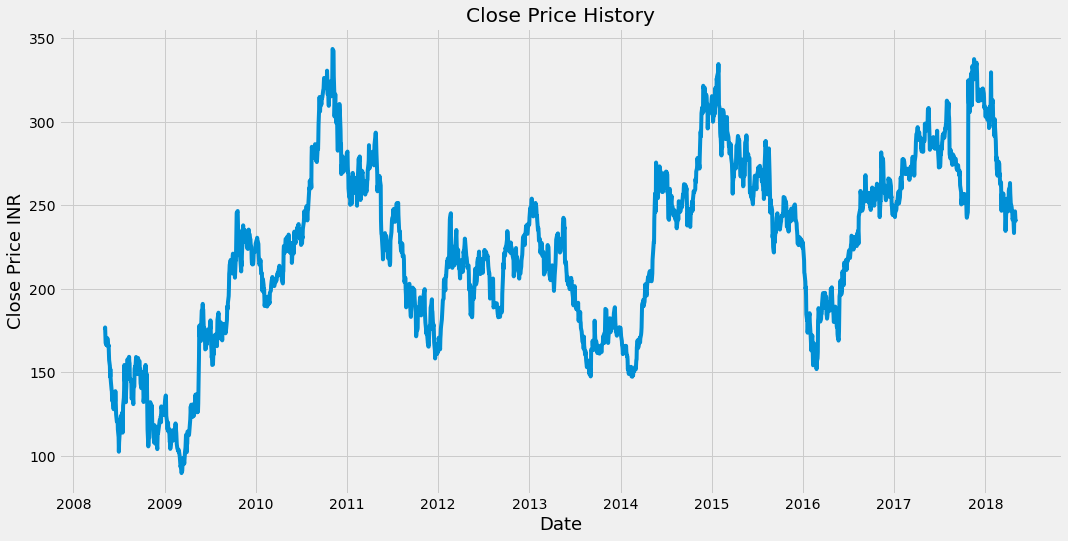

Epoch 1/5
64/64 [==============================] - 5s 44ms/step - loss: 0.0202
Epoch 2/5
64/64 [==============================] - 3s 45ms/step - loss: 0.0022
Epoch 3/5
64/64 [==============================] - 3s 44ms/step - loss: 0.0020
Epoch 4/5
64/64 [==============================] - 3s 45ms/step - loss: 0.0018
Epoch 5/5
64/64 [==============================] - 3s 47ms/step - loss: 0.0016
1.7796645333817651


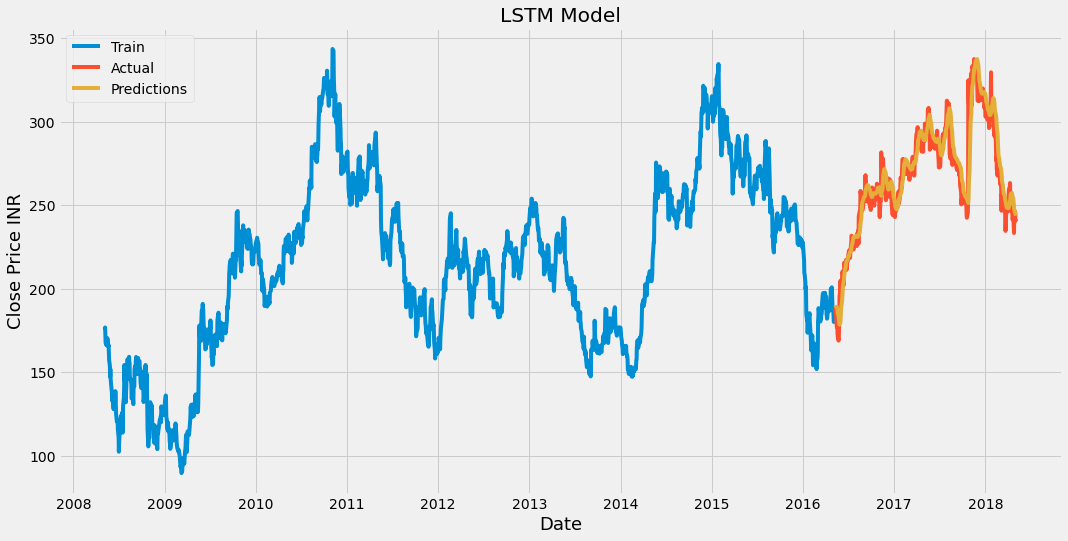

Predicted close Stock Price of the next day is 
 190.20327758789062,Actual is 184.949997


Stock Name: SUNPHARMA


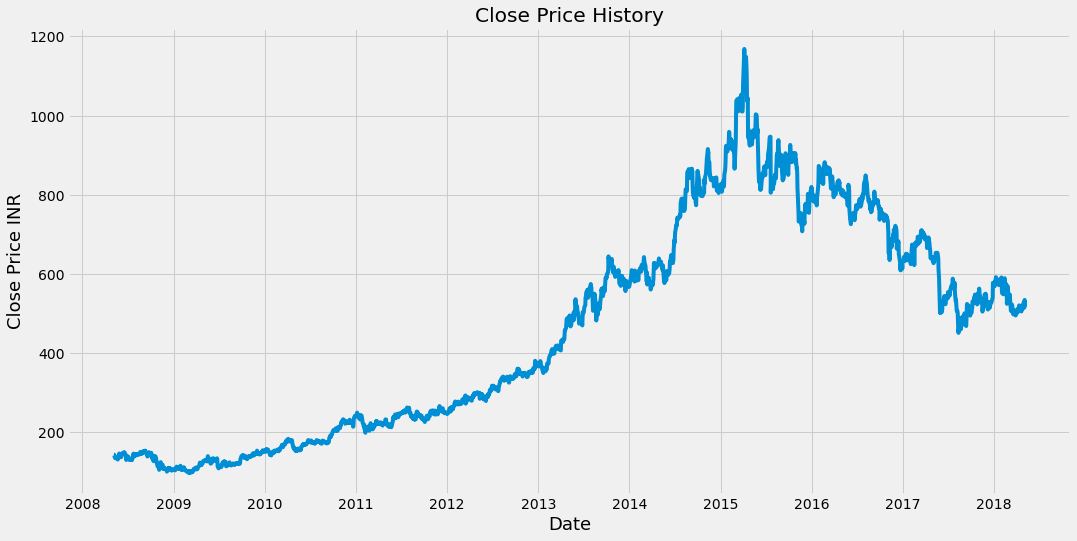

Epoch 1/5
64/64 [==============================] - 6s 49ms/step - loss: 0.0068:
Epoch 2/5
64/64 [==============================] - 4s 56ms/step - loss: 4.9005e-04
Epoch 3/5
64/64 [==============================] - 3s 50ms/step - loss: 5.0482e-04: 0s - loss: 5.0844
Epoch 4/5
64/64 [==============================] - 3s 51ms/step - loss: 4.6458e-04
Epoch 5/5
64/64 [==============================] - 3s 52ms/step - loss: 5.3039e-04
8.081276003441786


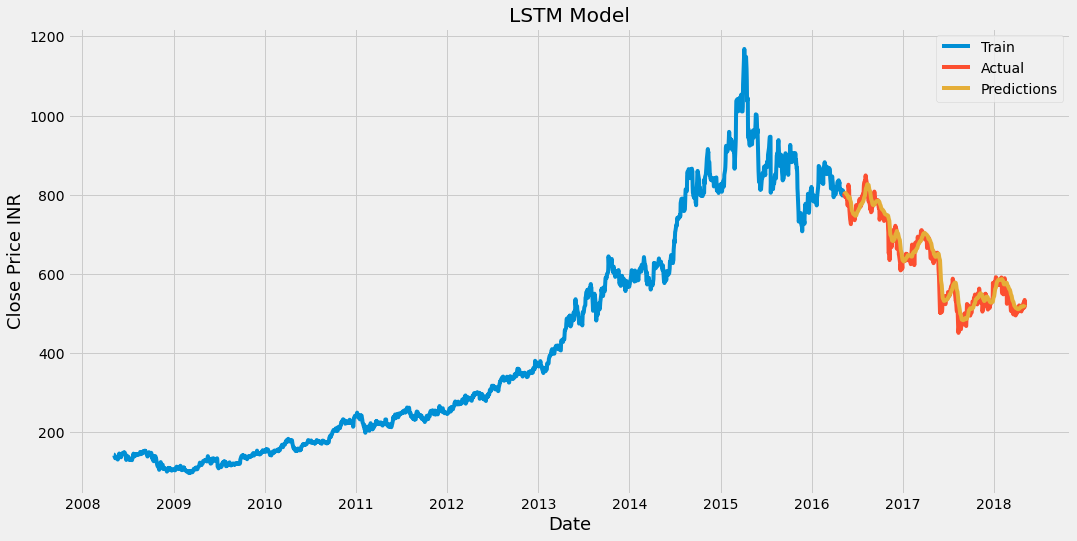

Predicted close Stock Price of the next day is 
 808.4512939453125,Actual is 796.099976


Stock Name: TATAMOTORS


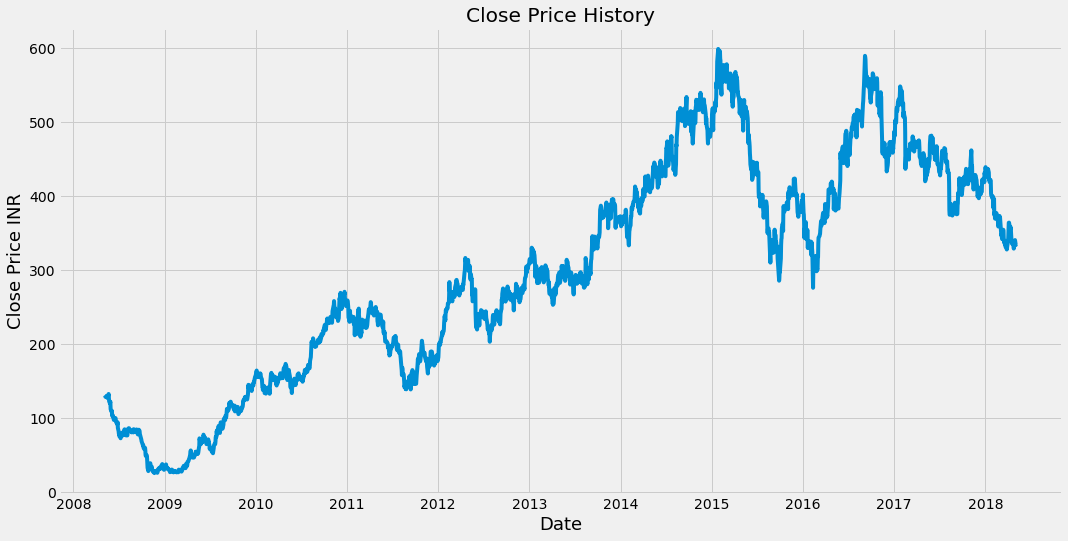

Epoch 1/5
64/64 [==============================] - 6s 48ms/step - loss: 0.0123: 1s - loss:  - ETA: 0s - loss: 0 - ETA: 0s -
Epoch 2/5
64/64 [==============================] - 3s 48ms/step - loss: 7.3648e-04
Epoch 3/5
64/64 [==============================] - 3s 48ms/step - loss: 7.0488e-04
Epoch 4/5
64/64 [==============================] - 3s 53ms/step - loss: 7.0421e-04
Epoch 5/5
64/64 [==============================] - 3s 49ms/step - loss: 6.4779e-04
7.56991020667397


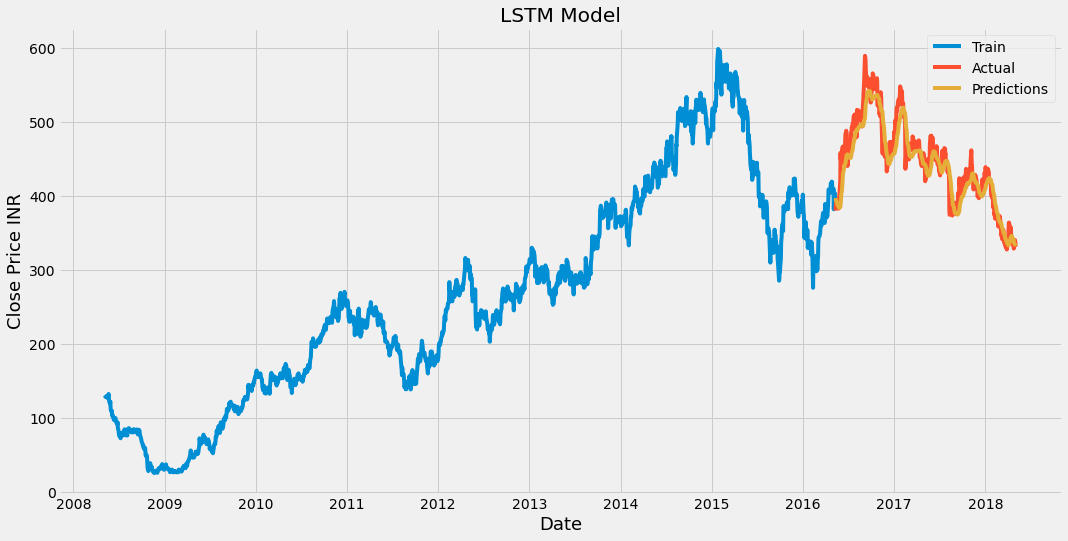

Predicted close Stock Price of the next day is 
 397.0318298339844,Actual is 380.100006


Stock Name: TATAMTRDVR


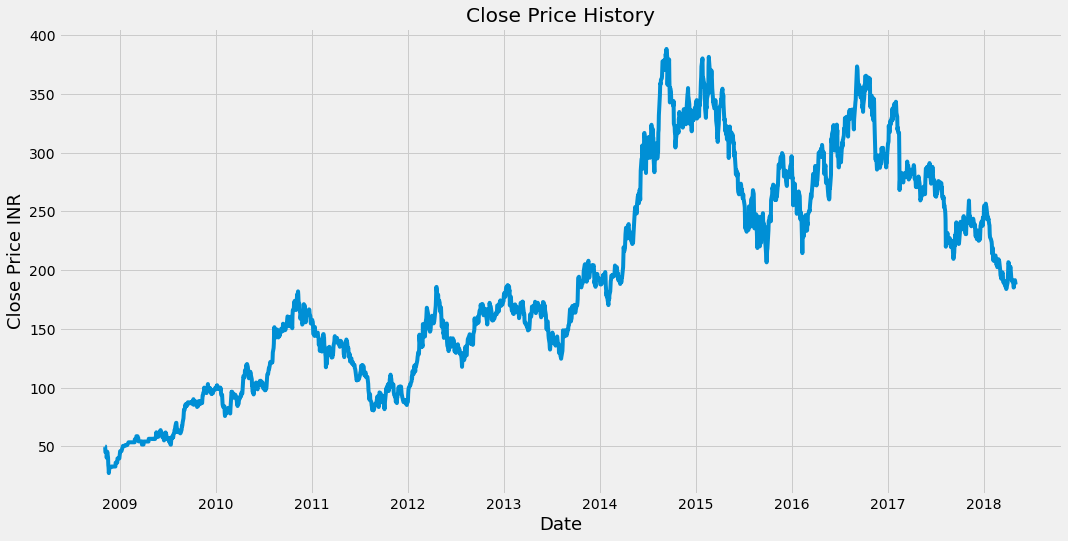

Epoch 1/5
60/60 [==============================] - 6s 51ms/step - loss: 0.0132
Epoch 2/5
60/60 [==============================] - 3s 52ms/step - loss: 0.0010
Epoch 3/5
60/60 [==============================] - 3s 53ms/step - loss: 9.3884e-04
Epoch 4/5
60/60 [==============================] - 3s 51ms/step - loss: 9.7480e-04
Epoch 5/5
60/60 [==============================] - 4s 65ms/step - loss: 9.5922e-04
11.241102736667708


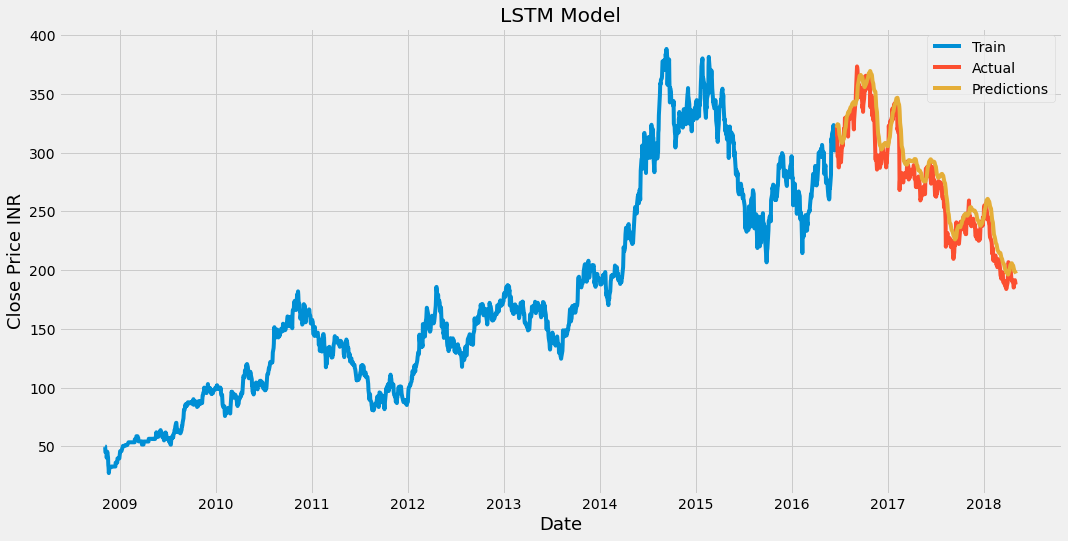

Predicted close Stock Price of the next day is 
 321.1720886230469,Actual is 323.850006


Stock Name: TATASTEEL


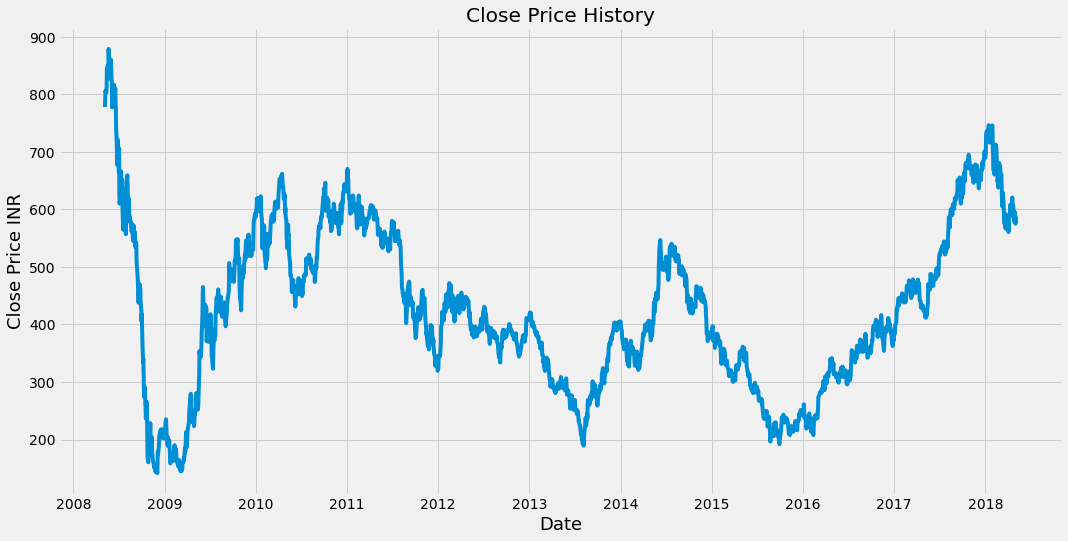

Epoch 1/5
64/64 [==============================] - 7s 54ms/step - loss: 0.0100
Epoch 2/5
64/64 [==============================] - 4s 59ms/step - loss: 0.0012
Epoch 3/5
64/64 [==============================] - 3s 52ms/step - loss: 0.0011
Epoch 4/5
64/64 [==============================] - 3s 50ms/step - loss: 9.3300e-04
Epoch 5/5
64/64 [==============================] - 3s 48ms/step - loss: 8.6411e-04
12.245516398945629


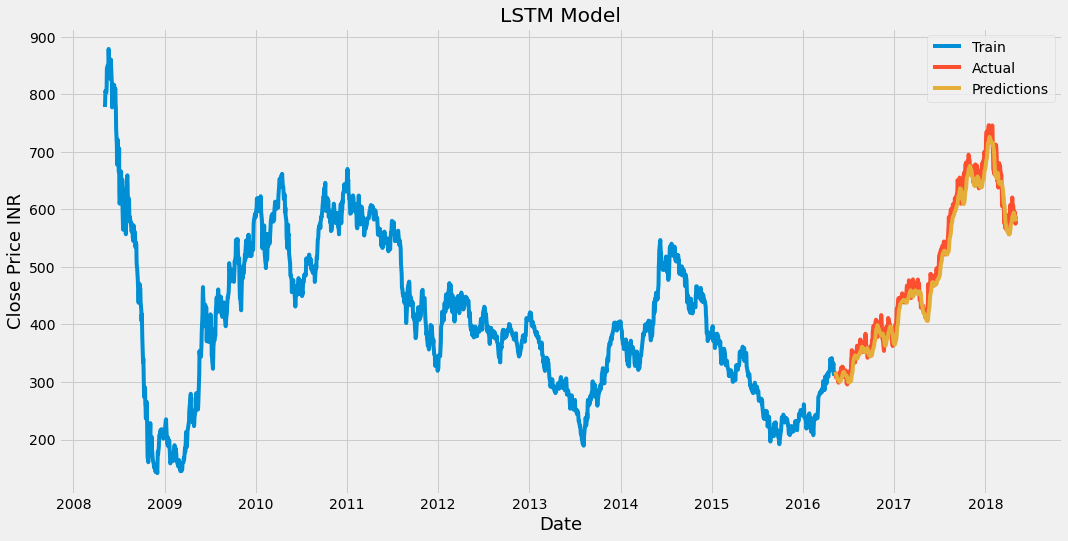

Predicted close Stock Price of the next day is 
 317.5965576171875,Actual is 313.462006


Stock Name: TCS


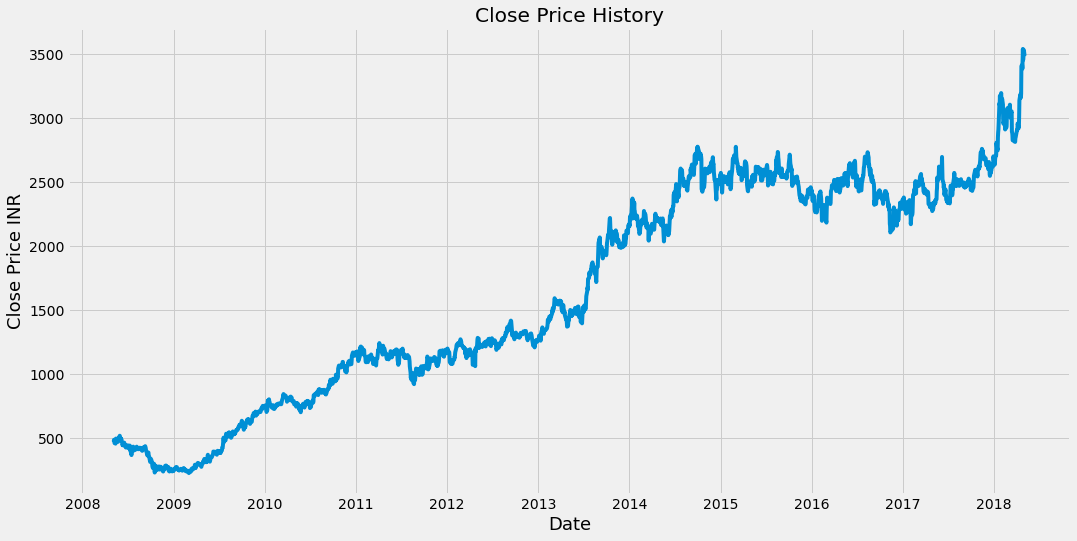

Epoch 1/5
64/64 [==============================] - 5s 48ms/step - loss: 0.0093
Epoch 2/5
64/64 [==============================] - 3s 50ms/step - loss: 2.5971e-04
Epoch 3/5
64/64 [==============================] - 3s 47ms/step - loss: 2.5582e-04
Epoch 4/5
64/64 [==============================] - 3s 51ms/step - loss: 2.4243e-04
Epoch 5/5
64/64 [==============================] - 3s 48ms/step - loss: 2.5078e-04
44.049868213541664


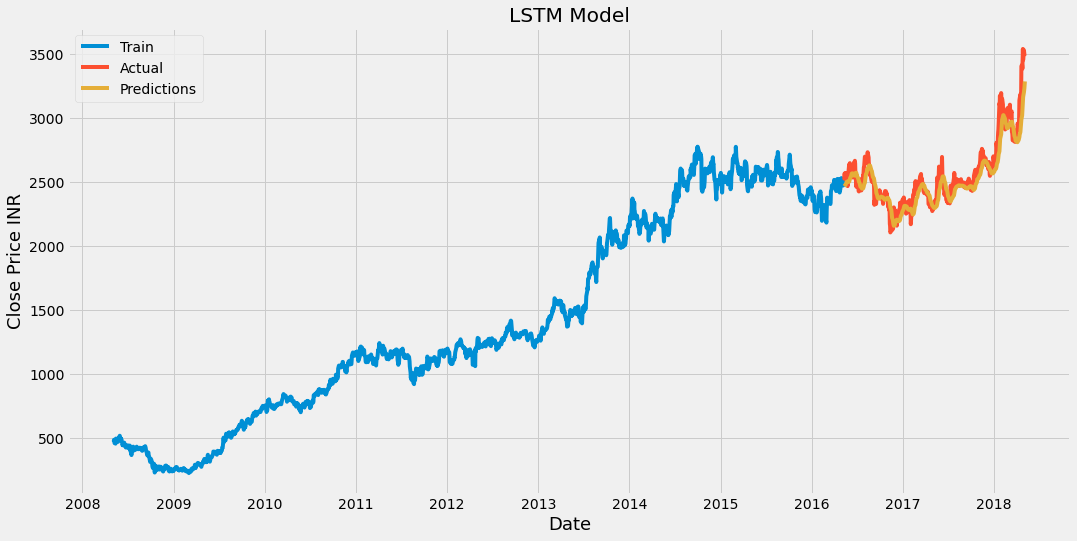

Predicted close Stock Price of the next day is 
 2466.040771484375,Actual is 2517.75


Stock Name: WIPRO


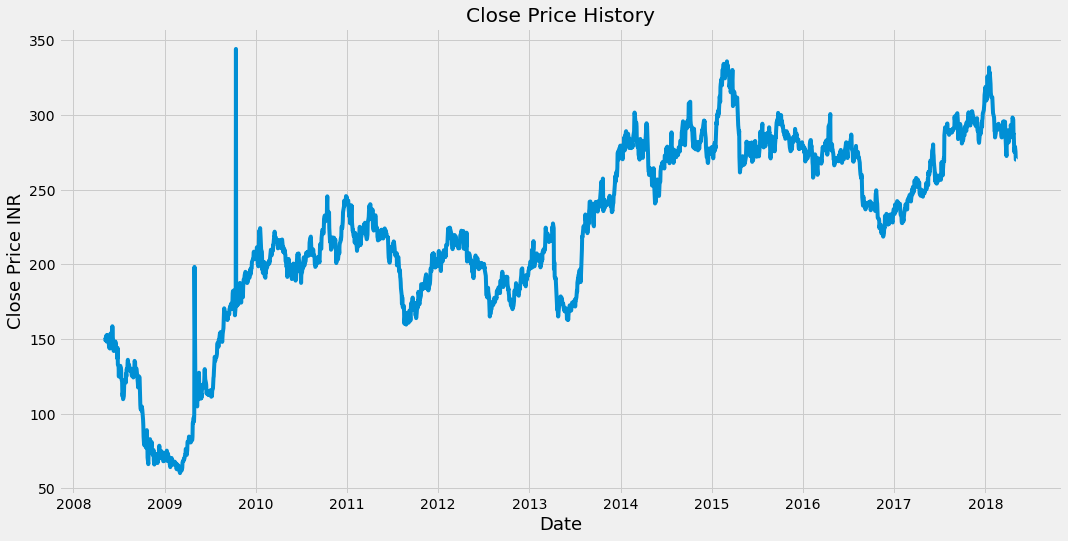

Epoch 1/5
64/64 [==============================] - 6s 50ms/step - loss: 0.0243
Epoch 2/5
64/64 [==============================] - 3s 52ms/step - loss: 0.0013
Epoch 3/5
64/64 [==============================] - 4s 55ms/step - loss: 0.0012
Epoch 4/5
64/64 [==============================] - 3s 53ms/step - loss: 0.0011 ETA: 1s -
Epoch 5/5
64/64 [==============================] - 4s 55ms/step - loss: 0.0011
1.2402970222426006


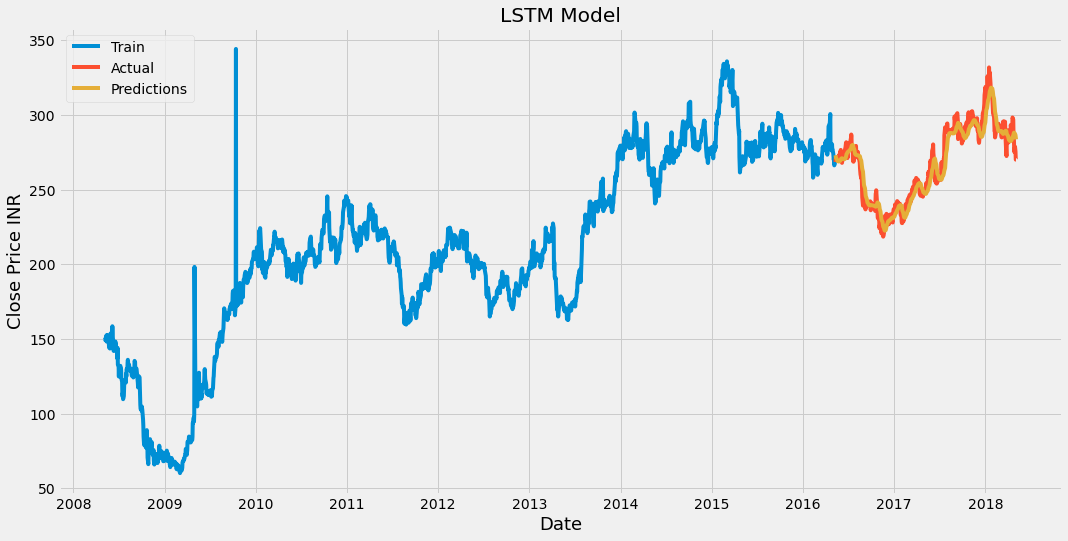

Predicted close Stock Price of the next day is 
 273.1091613769531,Actual is 268.575012


Stock Name: YESBANK


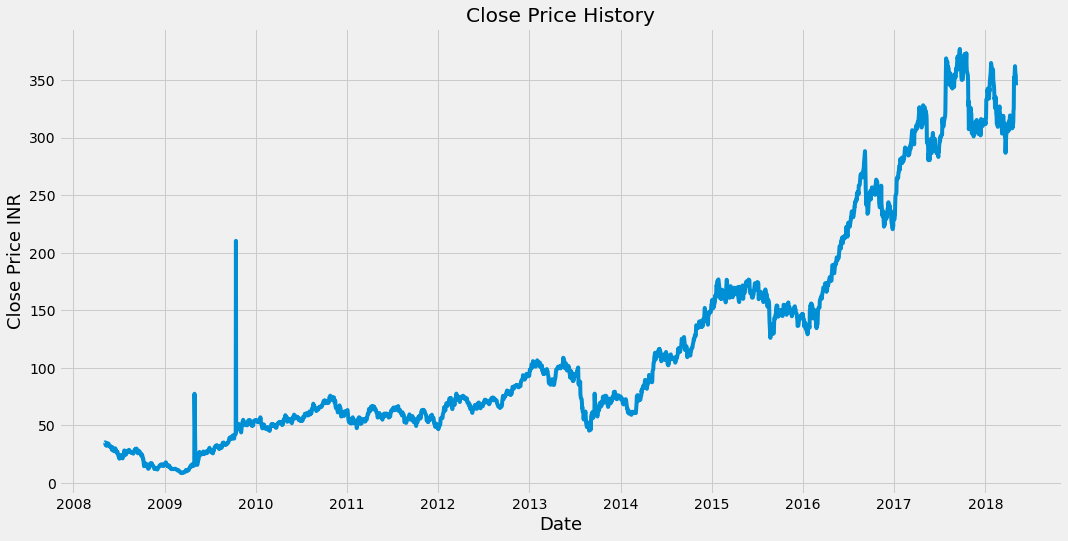

Epoch 1/5
64/64 [==============================] - 6s 45ms/step - loss: 0.0037
Epoch 2/5
64/64 [==============================] - 3s 50ms/step - loss: 3.3691e-04
Epoch 3/5
64/64 [==============================] - 3s 53ms/step - loss: 3.3717e-04
Epoch 4/5
64/64 [==============================] - 3s 54ms/step - loss: 3.5380e-04
Epoch 5/5
64/64 [==============================] - 3s 53ms/step - loss: 3.1176e-04: 0s - loss: 3
4.301543344222402


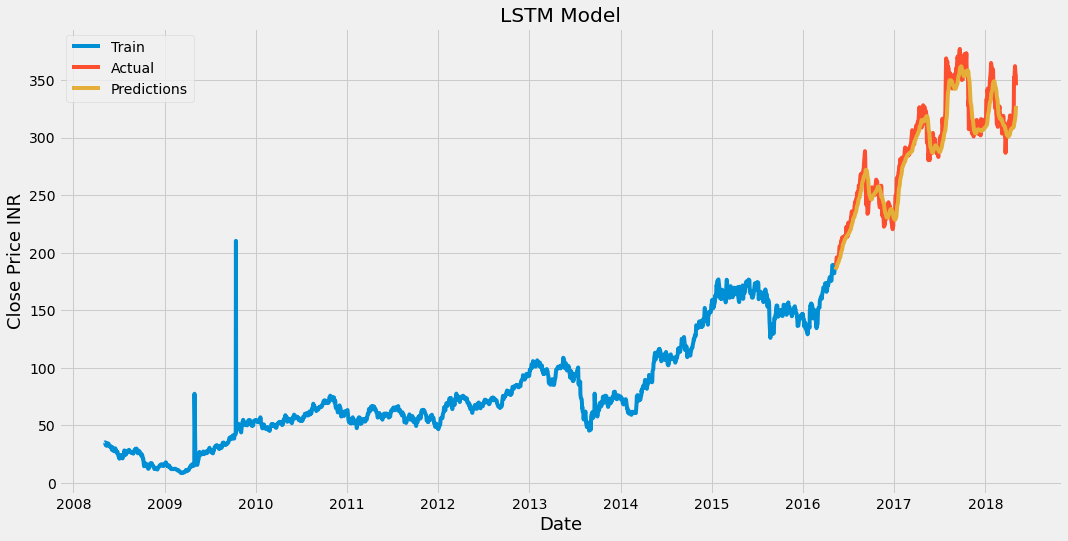

Predicted close Stock Price of the next day is 
 185.07762145996094,Actual is 191.25




Stock  Closing Price
0   ADANIPORTS     215.636536
1   ASIANPAINT     872.878723
2     AXISBANK     480.440796
3   BAJAJ-AUTO    2517.074463
4   BHARTIARTL     358.940552
5    COALINDIA     320.726135
6      DRREDDY    3009.245117
7         HDFC    1120.618408
8     HDFCBANK    1110.817261
9   HEROMOTOCO    2893.832275
10  HINDUNILVR     880.991516
11   ICICIBANK     203.366272
12  INDUSINDBK    1023.633362
13        INFY    1232.069092
14         ITC     213.744904
15   KOTAKBANK     677.825134
16          LT     846.724976
17         M&M     673.840332
18      MARUTI    3862.088379
19        ONGC     142.057587
20   POWERGRID     145.840500
21    RELIANCE     483.589203
22        SBIN     190.203278
23   SUNPHARMA     808.451294
24  TATAMOTORS     397.031830
25  TATAMTRDVR     321.172089
26   TATASTEEL     317.596558
27         TCS    2466.040771
28       WIPRO     273.109161
29     YESBANK     185.077621

In [8]:
path = os.getcwd()
csv_files = glob.glob(os.path.join('C:/Users/DIBYA/Capstone Project/StocksData/', "*.csv"))

StockClose = pd.DataFrame( columns = ['Stock','Closing Price'])

company_dict={}
# loop over the list of csv files
for f in csv_files:
    
    # read the csv file
    df = pd.read_csv(f)

    # print the location and filename
    #print('Location:', f)
    
    temp = f.split("\\")[-1]
    #print('File Name with Extension:', temp)
    print('Stock Name:', temp[:-4])
    
    if temp[:-4] not in company_dict:
        df = pd.read_csv(f)

        company_dict[temp[:-4]] = StockPredict(dataset = df)
        
    StockClose = StockClose.append({'Stock':temp[:-4],'Closing Price': company_dict[temp[:-4]]},ignore_index = True)
    print()
    print()
StockClose.to_csv("C:/Users/DIBYA/Capstone Project/StockClose.csv",index = False)
#print(company_dict)
StockClose

# Recommend Stocks on the Basis of risk

0 : No Risk <br /> 
1 : Low Risk<br /> 
2 : Medium Risk<br /> 
3 : High Risk<br /> 

In [11]:
NoRisk = pd.read_csv("NoRisk.csv")
Risk = pd.read_csv('StockRisk.csv')
Close = pd.read_csv('StockClose.csv')

Risk['Risk'][Risk['Risk'] == 'Low'] = 1
Risk['Risk'][Risk['Risk'] == 'Medium'] = 2
Risk['Risk'][Risk['Risk'] == 'High'] = 3

print("What is your risk taking apettite for your funds?")

print("0 : No Risk Very Low Return\n1 : Low Risk Low Return\n2 : Medium Risk Medium Return\n3 : High Risk High Return")
risk = int(input("Enter Corresponsing Number : "))


if risk == 0:
    print(NoRisk)
else:
    print("How much you want to invest?")
    invest = int(input("Enter Ammount : "))

    Temp1 = pd.DataFrame((Risk['Stock'][Risk['Risk'] == risk]).reset_index(drop=True))
    Temp2 = pd.DataFrame((Close['Stock'][Close['Closing Price'] <= invest]).reset_index(drop=True))
    Result = pd.merge(pd.merge(Temp1,Temp2, how='inner'),Close, how='inner')
    print(Result) 
    


What is your risk taking apettite for your funds?
0 : No Risk Very Low Return
1 : Low Risk Low Return
2 : Medium Risk Medium Return
3 : High Risk High Return
Enter Corresponsing Number : 2
How much you want to invest?
Enter Ammount : 800
        Stock  Closing Price
0         M&M      673.84033
1        SBIN      190.20328
2  TATAMTRDVR      321.17210
